Companies worldwide report their greenhouse gas emissions by dividing them between direct emissions (Scope 1) and indirect emissions (Scope 2). Multiplying the absolute emissions by the CO2 Damage Cost – the dollar cost for each ton of CO2-equivalent emitted – one obtains the Scope 1 and Scope 2 Damage Costs for all companies, as provided in the Excel file.

Given the difference in size of companies, it’s crucial to normalize the damage costs to be able to perform meaningful analysis on them. For this purpose, we propose to calculate the Impact Ratio, as the Damage Cost divided by the total revenues of each company. 
It’s expected that companies will have a higher or lower impact ratio depending on their business and the current case study aims to assess if this expectation meets reality.

**Data inputs:**

The attached Impact_Ratio_Assignment.xlsx contains data tables that may assist you in answering the queries below. You’re free to use other outside information to supplement the analysis, but you’re expected to use the data provided. The attached Excel contain the following sheets: 
1.	Table 1: The company’s Scope 1 and Scope 2 Damage Costs 
2.	Table 2: The company’s GICS industry allocation 

Scope 1 emissions are direct emissions from sources owned or controlled by an organization, while Scope 2 emissions are indirect emissions from purchased electricity, steam, heating, or cooling

In [239]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")

Loading data

In [240]:
# Load data
data_path = "Copy of Case Study_Data Scientist_S1_Impact_Ratio_Assignment (004).xlsx"
sheets = pd.read_excel(data_path, sheet_name=None, index_col=0)

damage_df = sheets["Table 1"]
industry_df = sheets["Table 2"]

# Join on CompanyID
df = industry_df.join(damage_df).sort_values("CompanyID")
assert len(df) == len(damage_df)  # Assert no company is left behind

# Rename columns
df.columns = ["IndustryGroup", "TotalRevenue", "DamageCost_Scope1", "DamageCost_Scope2"]

df.head(5)

IndustryGroup  TotalRevenue  DamageCost_Scope1  \
CompanyID                                                        
COM0001    Financial Services     16338.000           0.338315   
COM0002                 Banks       541.302           0.022633   
COM0003                 Banks      6943.000           0.240284   
COM0004                 Banks      7661.559           0.928260   
COM0005                 Banks      7823.000           0.523893   

           DamageCost_Scope2  
CompanyID                     
COM0001             4.247979  
COM0002             0.134260  
COM0003             2.613041  
COM0004             1.819234  
COM0005             2.927635

## Data Analysis

An EDA before starting with the exercises

In [241]:
df.describe()

TotalRevenue  DamageCost_Scope1  DamageCost_Scope2
count    2897.000000       2.897000e+03        2897.000000
mean     8913.320889       4.349717e+04          15.767660
std     23854.406534       2.335915e+06          69.893906
min         0.121100       0.000000e+00           0.000000
25%       912.898386       1.801503e-01           0.381507
50%      2612.386613       1.390032e+00           1.823798
75%      7626.000000       1.152834e+01           8.721362
max    493700.155599       1.257279e+08        2179.249475

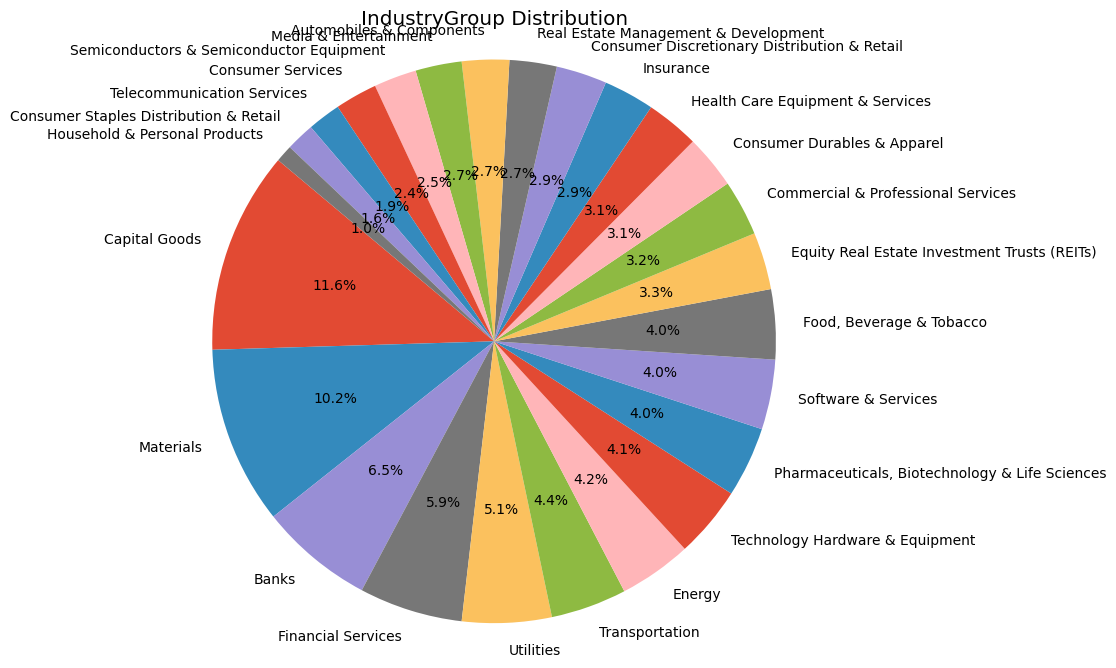

IndustryGroup
Capital Goods                                     402
Materials                                         354
Banks                                             227
Financial Services                                206
Utilities                                         178
Transportation                                    151
Energy                                            145
Technology Hardware & Equipment                   142
Pharmaceuticals, Biotechnology & Life Sciences    140
Software & Services                               139
Food, Beverage & Tobacco                          139
Equity Real Estate Investment Trusts (REITs)      114
Commercial & Professional Services                111
Consumer Durables & Apparel                       107
Health Care Equipment & Services                  106
Insurance                                         101
Consumer Discretionary Distribution & Retail      101
Real Estate Management & Development               94
Automobiles & 

In [242]:
# Pie chart of value counts for IndustryGroup
industry_counts = df.value_counts("IndustryGroup")
plt.figure(figsize=(8, 8))
plt.pie(
    industry_counts, labels=industry_counts.index, autopct="%1.1f%%", startangle=140
)
plt.title("IndustryGroup Distribution")
plt.axis("equal")
plt.show()

industry_counts

### Missing values

Checking for missing values in the data.

In [243]:
df.isna().sum()

IndustryGroup          0
TotalRevenue         572
DamageCost_Scope1    572
DamageCost_Scope2    572
dtype: int64

In [244]:
nan_companies = df.isna().any(axis=1)
df_nan = df[nan_companies]
df_nan

IndustryGroup  TotalRevenue  \
CompanyID                                                                 
COM0011                                             Banks           NaN   
COM0016                                             Banks           NaN   
COM0017                                             Banks           NaN   
COM0018                                             Banks           NaN   
COM0020                                             Banks           NaN   
...                                                   ...           ...   
COM3465                                         Materials           NaN   
COM3466                               Software & Services           NaN   
COM3467                                Financial Services           NaN   
COM3468    Pharmaceuticals, Biotechnology & Life Sciences           NaN   
COM3469                Commercial & Professional Services           NaN   

           DamageCost_Scope1  DamageCost_Scope2  
CompanyID                                        
COM0011                  NaN                NaN  
COM0016                  NaN                NaN  
COM0017                  NaN                NaN  
COM0018                  NaN                NaN  
COM0020                  NaN                NaN  
...                      ...                ...  
COM3465                  NaN                NaN  
COM3466                  NaN                NaN  
COM3467                  NaN                NaN  
COM3468                  NaN                NaN  
COM3469                  NaN                NaN  

[572 rows x 4 columns]

Missing values are present across the whole row, not randomly across columns

In [245]:
df_nan.describe()

TotalRevenue  DamageCost_Scope1  DamageCost_Scope2
count           0.0                0.0                0.0
mean            NaN                NaN                NaN
std             NaN                NaN                NaN
min             NaN                NaN                NaN
25%             NaN                NaN                NaN
50%             NaN                NaN                NaN
75%             NaN                NaN                NaN
max             NaN                NaN                NaN

They happen in all industries.

I won't do it, but it could be interesting to check if the industries with more missing values are the ones with higher emissions. Assuming that they are withholding information on purpose

In [246]:
df_nan.fillna(1).groupby("IndustryGroup").count()[
    "TotalRevenue"
].sort_values(ascending=False)

IndustryGroup
Capital Goods                                     64
Financial Services                                52
Banks                                             41
Materials                                         40
Software & Services                               34
Insurance                                         26
Media & Entertainment                             25
Pharmaceuticals, Biotechnology & Life Sciences    23
Consumer Services                                 23
Health Care Equipment & Services                  22
Consumer Durables & Apparel                       20
Consumer Discretionary Distribution & Retail      20
Transportation                                    19
Energy                                            18
Commercial & Professional Services                18
Food, Beverage & Tobacco                          16
Equity Real Estate Investment Trusts (REITs)      16
Real Estate Management & Development              14
Automobiles & Components        

```text
Given the context of the data, it doesn't seem that the missing values originate from mistakes in data collection, more likely the companies simply do not report their emissions.

So for now I will remove them to keep the analysis clean.

When assigning a score, I will probably do some imputation. Zero does not make sense as it would imply that the company has no emissions, infinite would penalize heavily.
I will probably estimate something in relation to the industry, maybe combining the average for both Scope 1 and Scope 2 emissions.
```

In [247]:
# Dropping for now
df = df[np.logical_not(nan_companies)]

# Checking all industries have at least one company left
df.value_counts("IndustryGroup")

IndustryGroup
Capital Goods                                     338
Materials                                         314
Banks                                             186
Utilities                                         167
Financial Services                                154
Transportation                                    132
Technology Hardware & Equipment                   129
Energy                                            127
Food, Beverage & Tobacco                          123
Pharmaceuticals, Biotechnology & Life Sciences    117
Software & Services                               105
Equity Real Estate Investment Trusts (REITs)       98
Commercial & Professional Services                 93
Consumer Durables & Apparel                        87
Health Care Equipment & Services                   84
Consumer Discretionary Distribution & Retail       81
Real Estate Management & Development               80
Automobiles & Components                           80
Semiconductors

### Visualizing features

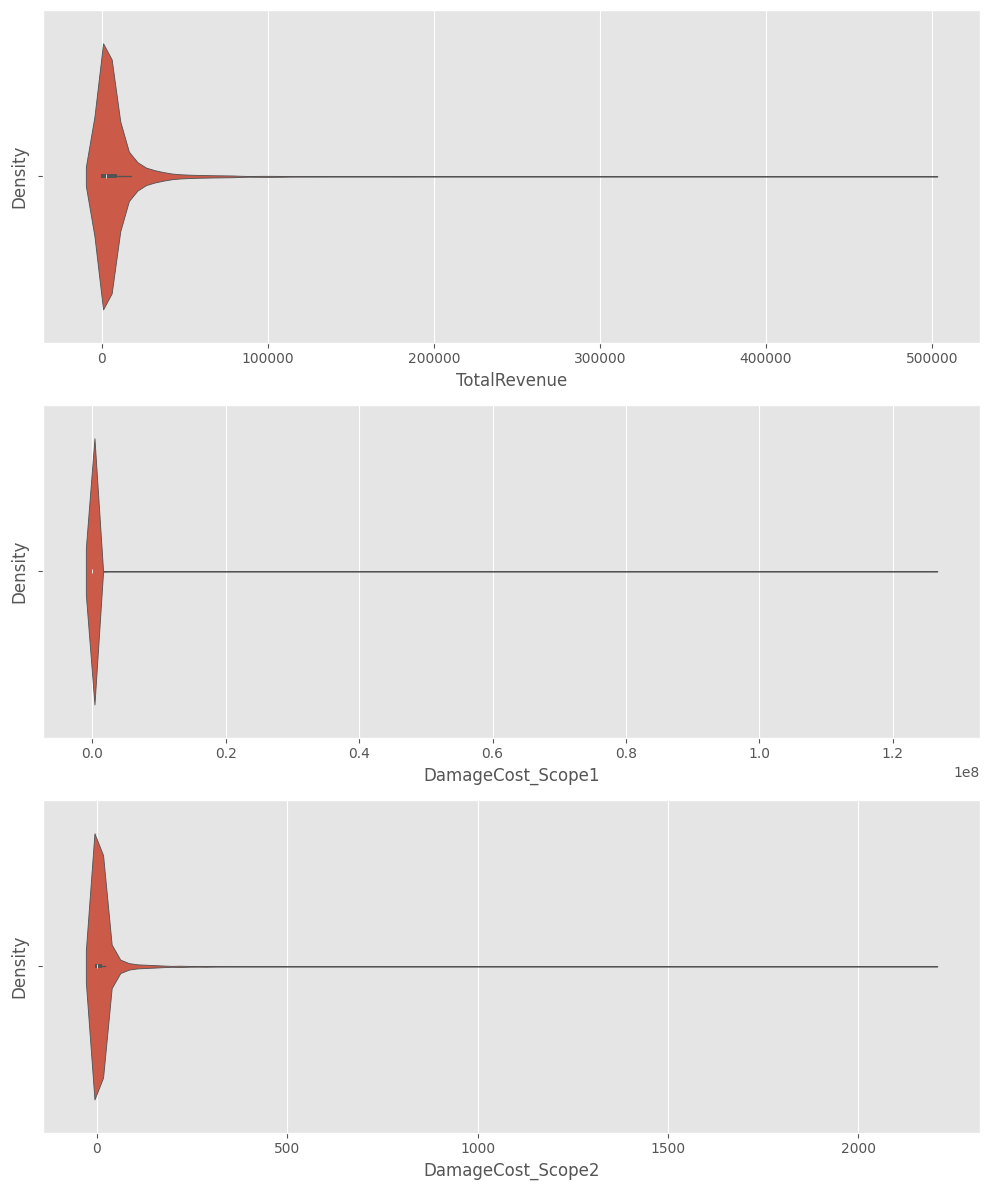

In [248]:
features = ["TotalRevenue", "DamageCost_Scope1", "DamageCost_Scope2"]

fig, axes = plt.subplots(len(features), 1, figsize=(10, 12))
for i, feature in enumerate(features):
    sns.violinplot(df, x=feature, ax=axes[i])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Density")
    # Optionally, use log scale for highly skewed data
    # axes[i].set_xscale("log")

plt.tight_layout()
plt.show()

```text
Highly skewed
```

### Analyzing outliers

I would ask why are they outliers. Again, given the context they probably are not mistakes, just companies with high revenue or emissions

In [249]:
# Defining as outlier those above the q75
q75_revenue = np.quantile(df["TotalRevenue"], q=0.75)
q75_direct = np.quantile(df["DamageCost_Scope1"], q=0.75)
q75_indirect = np.quantile(df["DamageCost_Scope2"], q=0.75)

# Get a list of companies that are outliers
df_outliers = pd.DataFrame(df["IndustryGroup"])
df_outliers["IsOutlier"] = (
    (df["TotalRevenue"] > q75_revenue)
    | (df["DamageCost_Scope1"] > q75_direct)
    | (df["DamageCost_Scope2"] > q75_indirect)
)

C:\Users\n118768\AppData\Local\Temp\ipykernel_16988\1008978620.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


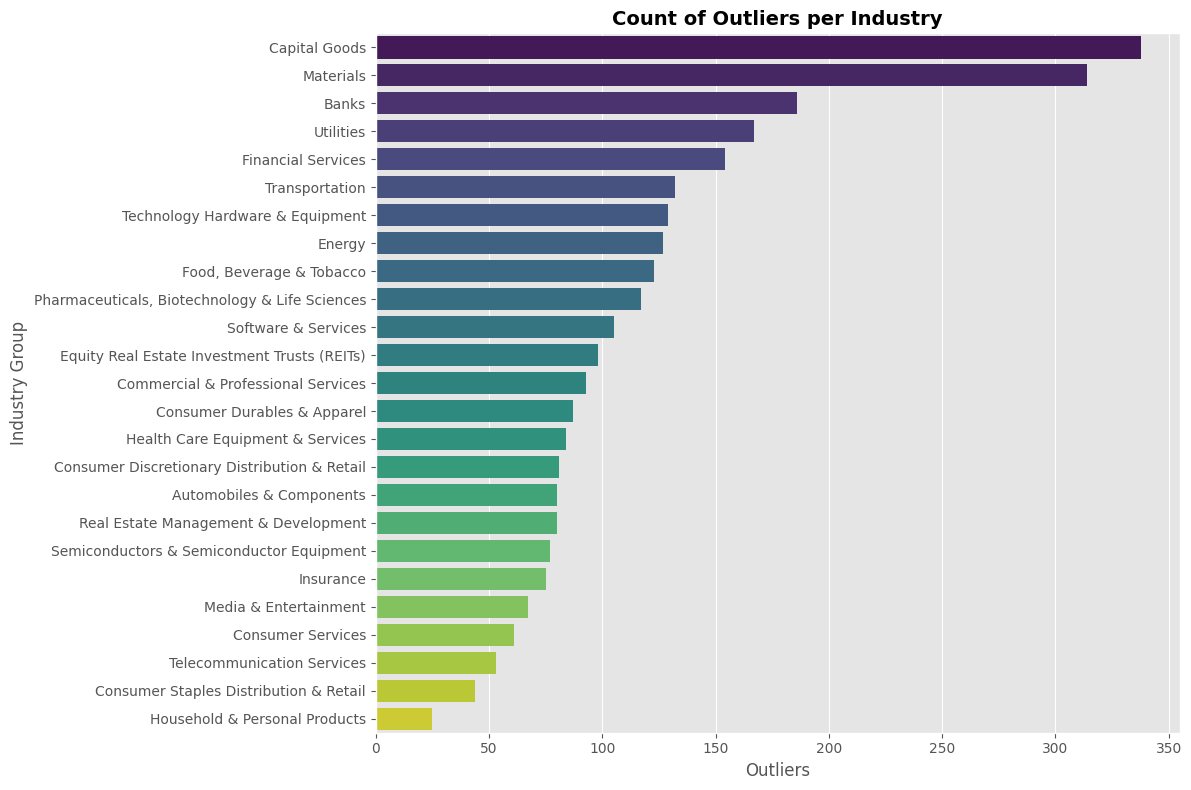

In [250]:
# Plot histogram of count of outliers per industry
plt.figure(figsize=(12, 8))
sns.countplot(
    data=df_outliers,
    y="IndustryGroup",
    order=df_outliers["IndustryGroup"].value_counts().index,
    palette="viridis",
    # hue="IsOutlier",
    legend=False
)
plt.title("Count of Outliers per Industry", fontsize=14, fontweight="bold")
plt.xlabel("Outliers", fontsize=12)
plt.ylabel("Industry Group", fontsize=12)
plt.tight_layout()
plt.show()

Would be interesting to check if the industries with more outliers are the ones with higher variance in emissions

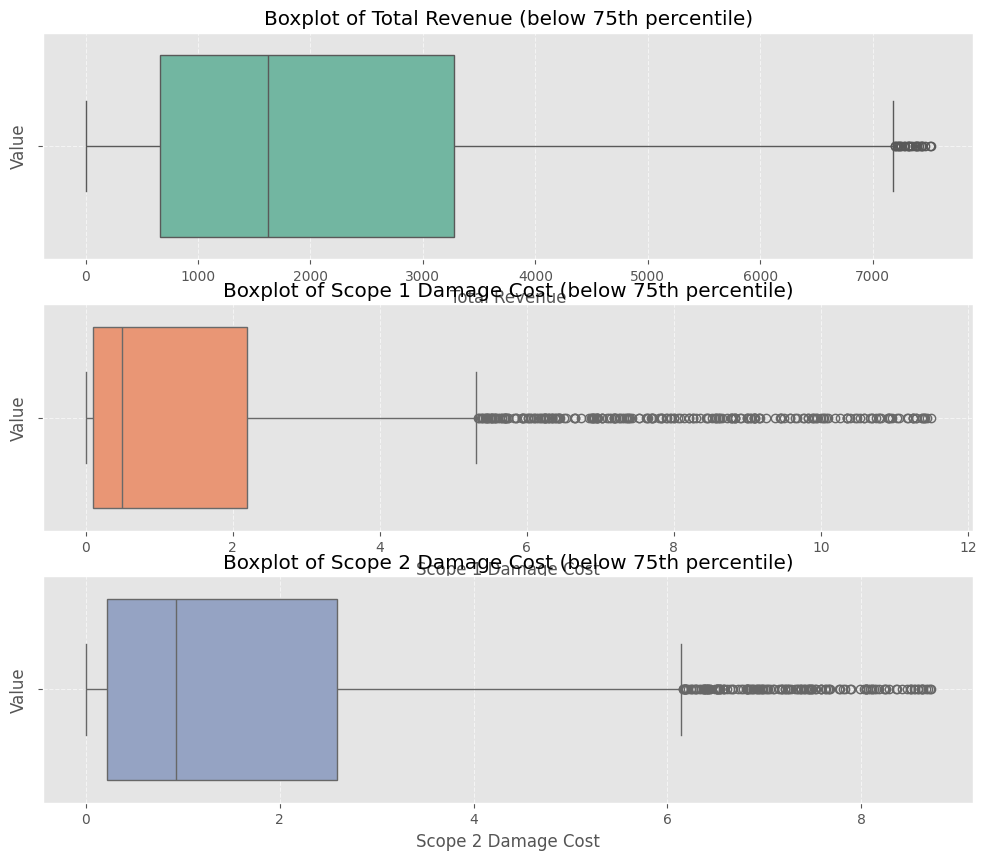

In [251]:
# Plotting without outliers
features = [
    ("TotalRevenue", q75_revenue, "Total Revenue"),
    ("DamageCost_Scope1", q75_direct, "Scope 1 Damage Cost"),
    ("DamageCost_Scope2", q75_indirect, "Scope 2 Damage Cost"),
]

fig, axes = plt.subplots(3, 1, figsize=(12, 10))
palette = sns.color_palette("Set2")
for i, (feature, q75, title) in enumerate(features):
    sns.boxplot(data=df[df[feature] < q75], x=feature, ax=axes[i], color=palette[i])
    axes[i].set_title(f"Boxplot of {title} (below 75th percentile)")
    axes[i].set_xlabel(title)
    axes[i].set_ylabel("Value")
    axes[i].grid(True, linestyle="--", alpha=0.6)

C:\Users\n118768\AppData\Local\Temp\ipykernel_16988\1290150039.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


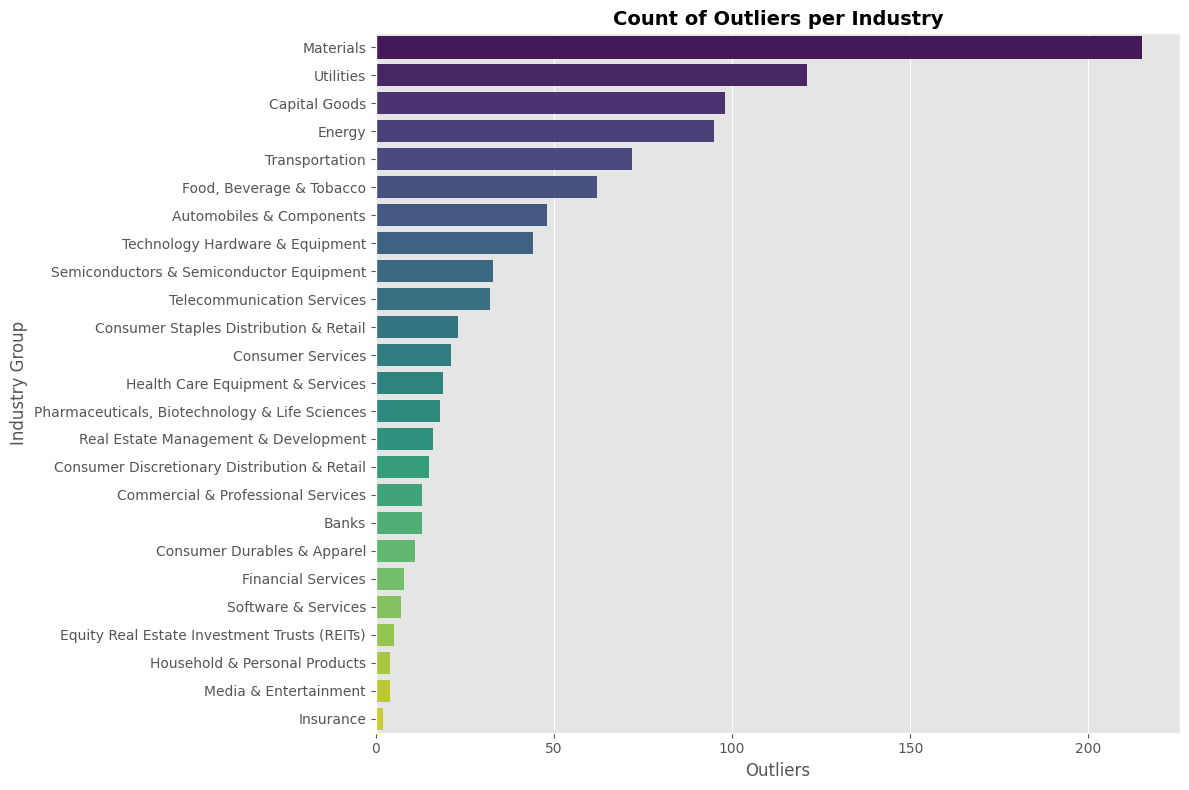

In [252]:
# Now without revenue
df_outliers["IsOutlier"] = (
    (df["DamageCost_Scope1"] > q75_direct)
    | (df["DamageCost_Scope2"] > q75_indirect)
)
df_outliers = df_outliers[df_outliers["IsOutlier"]]

# Plot histogram of count of outliers per industry
plt.figure(figsize=(12, 8))
sns.countplot(
    data=df_outliers,
    y="IndustryGroup",
    order=df_outliers["IndustryGroup"].value_counts().index,
    palette="viridis",
    legend=False
)
plt.title("Count of Outliers per Industry", fontsize=14, fontweight="bold")
plt.xlabel("Outliers", fontsize=12)
plt.ylabel("Industry Group", fontsize=12)
plt.tight_layout()
plt.show()

## Exercise 1:

> As Data Scientist you’re tasked to analyze environmental data coming from an internal database, covering Scope 1 and Scope 2 Damage Costs and Revenues (please note not all companies have data available). 
The target of this first exercise is to calculate the Impact Ratios of companies and to create a narrative around industries with higher and lower Impact Ratios. The Impact Ratio of a company is defined as the Damage Cost divided by the Total Revenues. These values are provided in the Table 1 of the Excel provided, for Scope 1 and Scope 2. Industries are separately provided in Table 2. 

**Calculating Impact Ratios**

In [253]:
df["ImpactRatio_Scope1"] = df["DamageCost_Scope1"] / df["TotalRevenue"]
df["ImpactRatio_Scope2"] = df["DamageCost_Scope2"] / df["TotalRevenue"]

In [254]:
df.describe()

TotalRevenue  DamageCost_Scope1  DamageCost_Scope2  \
count    2897.000000       2.897000e+03        2897.000000   
mean     8913.320889       4.349717e+04          15.767660   
std     23854.406534       2.335915e+06          69.893906   
min         0.121100       0.000000e+00           0.000000   
25%       912.898386       1.801503e-01           0.381507   
50%      2612.386613       1.390032e+00           1.823798   
75%      7626.000000       1.152834e+01           8.721362   
max    493700.155599       1.257279e+08        2179.249475   

       ImpactRatio_Scope1  ImpactRatio_Scope2  
count         2897.000000         2897.000000  
mean             0.833821            0.002421  
std             44.194297            0.012471  
min              0.000000            0.000000  
25%              0.000109            0.000247  
50%              0.000540            0.000682  
75%              0.002815            0.002124  
max           2378.714582            0.627570

In [255]:
# Apply log scale to the axes
df["ImpactRatio_Scope1"] = df["ImpactRatio_Scope1"].replace(0, np.nan)
df["ImpactRatio_Scope2"] = df["ImpactRatio_Scope2"].replace(0, np.nan)

df["Log_ImpactRatio_Scope1"] = np.log10(df["ImpactRatio_Scope1"])
df["Log_ImpactRatio_Scope2"] = np.log10(df["ImpactRatio_Scope2"])

In [256]:
# Sort columns by ratio
df_industry = df.groupby(
    "IndustryGroup"
).median()  # Median less sensitive to outliers than mean

order_scope1 = df_industry.sort_values(
    "ImpactRatio_Scope1", ascending=False
).index
order_scope2 = df_industry.sort_values(
    "ImpactRatio_Scope2", ascending=False
).index

order_colors_scope1 = sns.color_palette("RdYlGn_r", n_colors=len(order_scope1))
order_colors_scope2 = sns.color_palette("coolwarm", n_colors=len(order_scope1))

# We reverse the order to have the highest impact ratios at the top
order_colors_scope1.reverse()
order_colors_scope2.reverse()

**Visualizing Impact Ratios**

Hypothesis to test: It’s expected that companies will have a higher or lower impact ratio depending on their business

Text(0.5, 1.0, 'Scope 2 Impact Ratios by Industry')

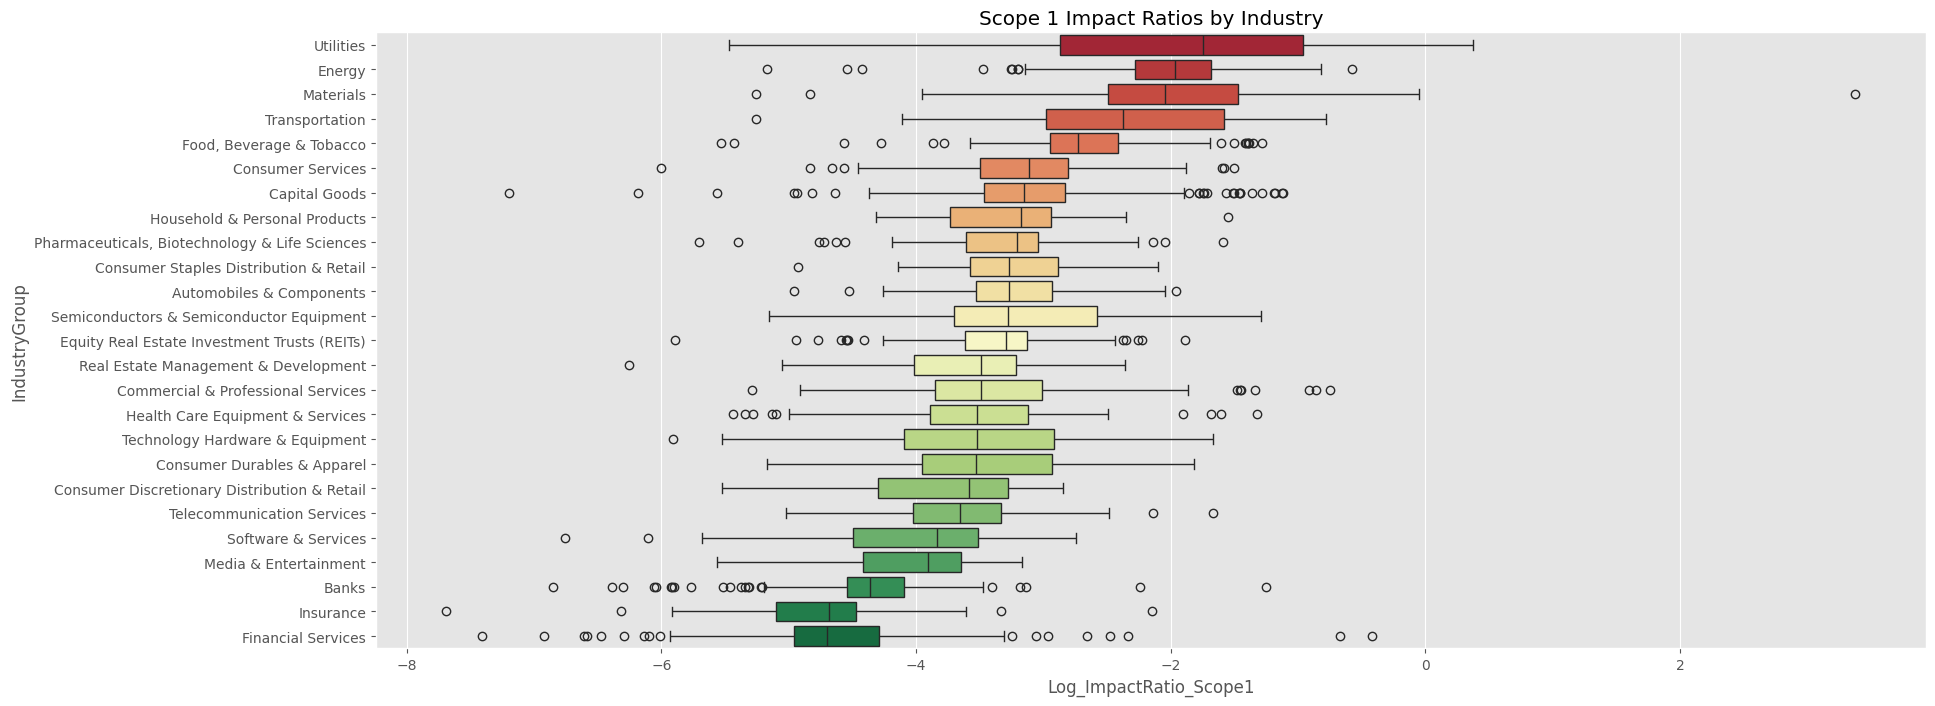

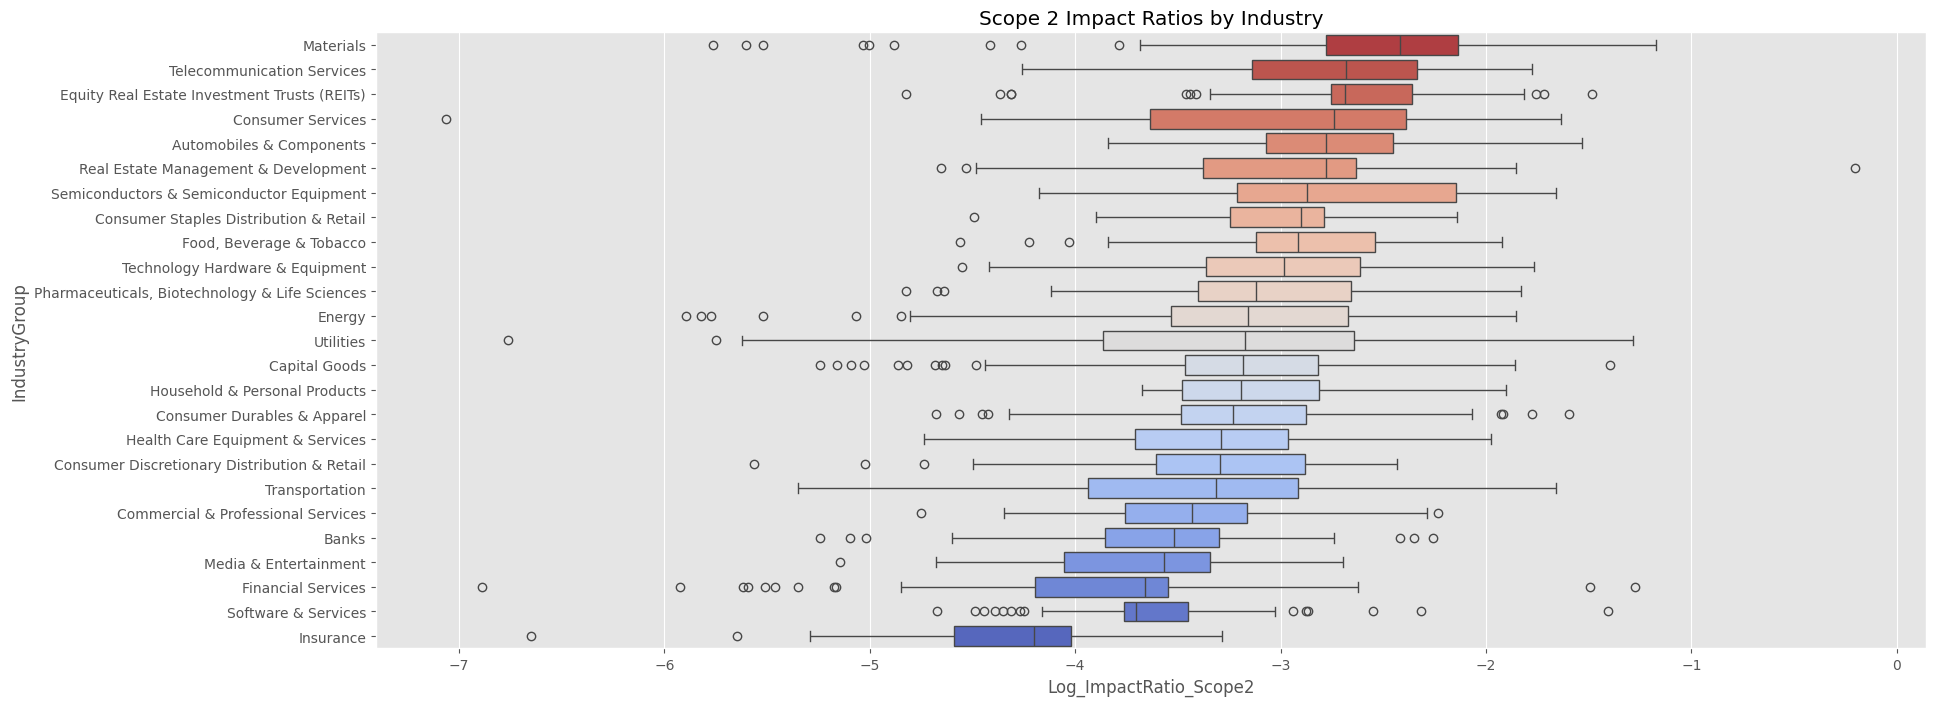

In [257]:
# Boxplot of Impact Ratios
plt.figure(figsize=(20, 8))
sns.boxplot(
    data=df,
    x="Log_ImpactRatio_Scope1",
    y="IndustryGroup",
    order=order_scope1,
    hue="IndustryGroup",
    hue_order=order_scope1,
    palette=order_colors_scope1,
)
plt.title("Scope 1 Impact Ratios by Industry")

# Boxplot of Impact Ratios
plt.figure(figsize=(20, 8))
sns.boxplot(
    data=df,
    x="Log_ImpactRatio_Scope2",
    y="IndustryGroup",
    order=order_scope2,
    hue="IndustryGroup",
    hue_order=order_scope2,
    palette=order_colors_scope2,
)
plt.title("Scope 2 Impact Ratios by Industry")

Clearly there is a difference in impact ratios between industries. For Scope 1 as well as Scope 2.

We could conduct a test (e.g. t-test) to check if the difference is statistically significant, but visually it is already clear that there is a difference.

In [258]:
def plot_industrygroup_hist_split(df, order, column, log_scale=True, figsize=(20, 15)):
    """Plot histogram of a column split by half of IndustryGroups in two subplots."""
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharey=True)
    industry_groups = list(order)
    mid = len(industry_groups) // 2
    groups1 = industry_groups[:mid]
    groups2 = industry_groups[mid:]

    # Determine common x-axis limits for both subplots
    xmin = df[column].min()
    xmax = df[column].max()

    # First half of IndustryGroups
    sns.histplot(
        df[df["IndustryGroup"].isin(groups1)],
        x=column,
        log_scale=log_scale,
        hue="IndustryGroup",
        hue_order=groups1,
        ax=axes[0],
        # multiple="stack",
    )
    axes[0].set_title(f"IndustryGroup (First Half) - {column}")
    axes[0].set_xlim(xmin, xmax)
    axes[0].set_xlabel(column)

    # Second half of IndustryGroups
    sns.histplot(
        df[df["IndustryGroup"].isin(groups2)],
        x=column,
        log_scale=log_scale,
        hue="IndustryGroup",
        hue_order=groups2,
        ax=axes[1],
        # multiple="stack",
    )
    axes[1].set_title(f"IndustryGroup (Second Half) - {column}")
    axes[1].set_xlim(xmin, xmax)
    axes[1].set_xlabel(column)

    plt.tight_layout()
    plt.show()

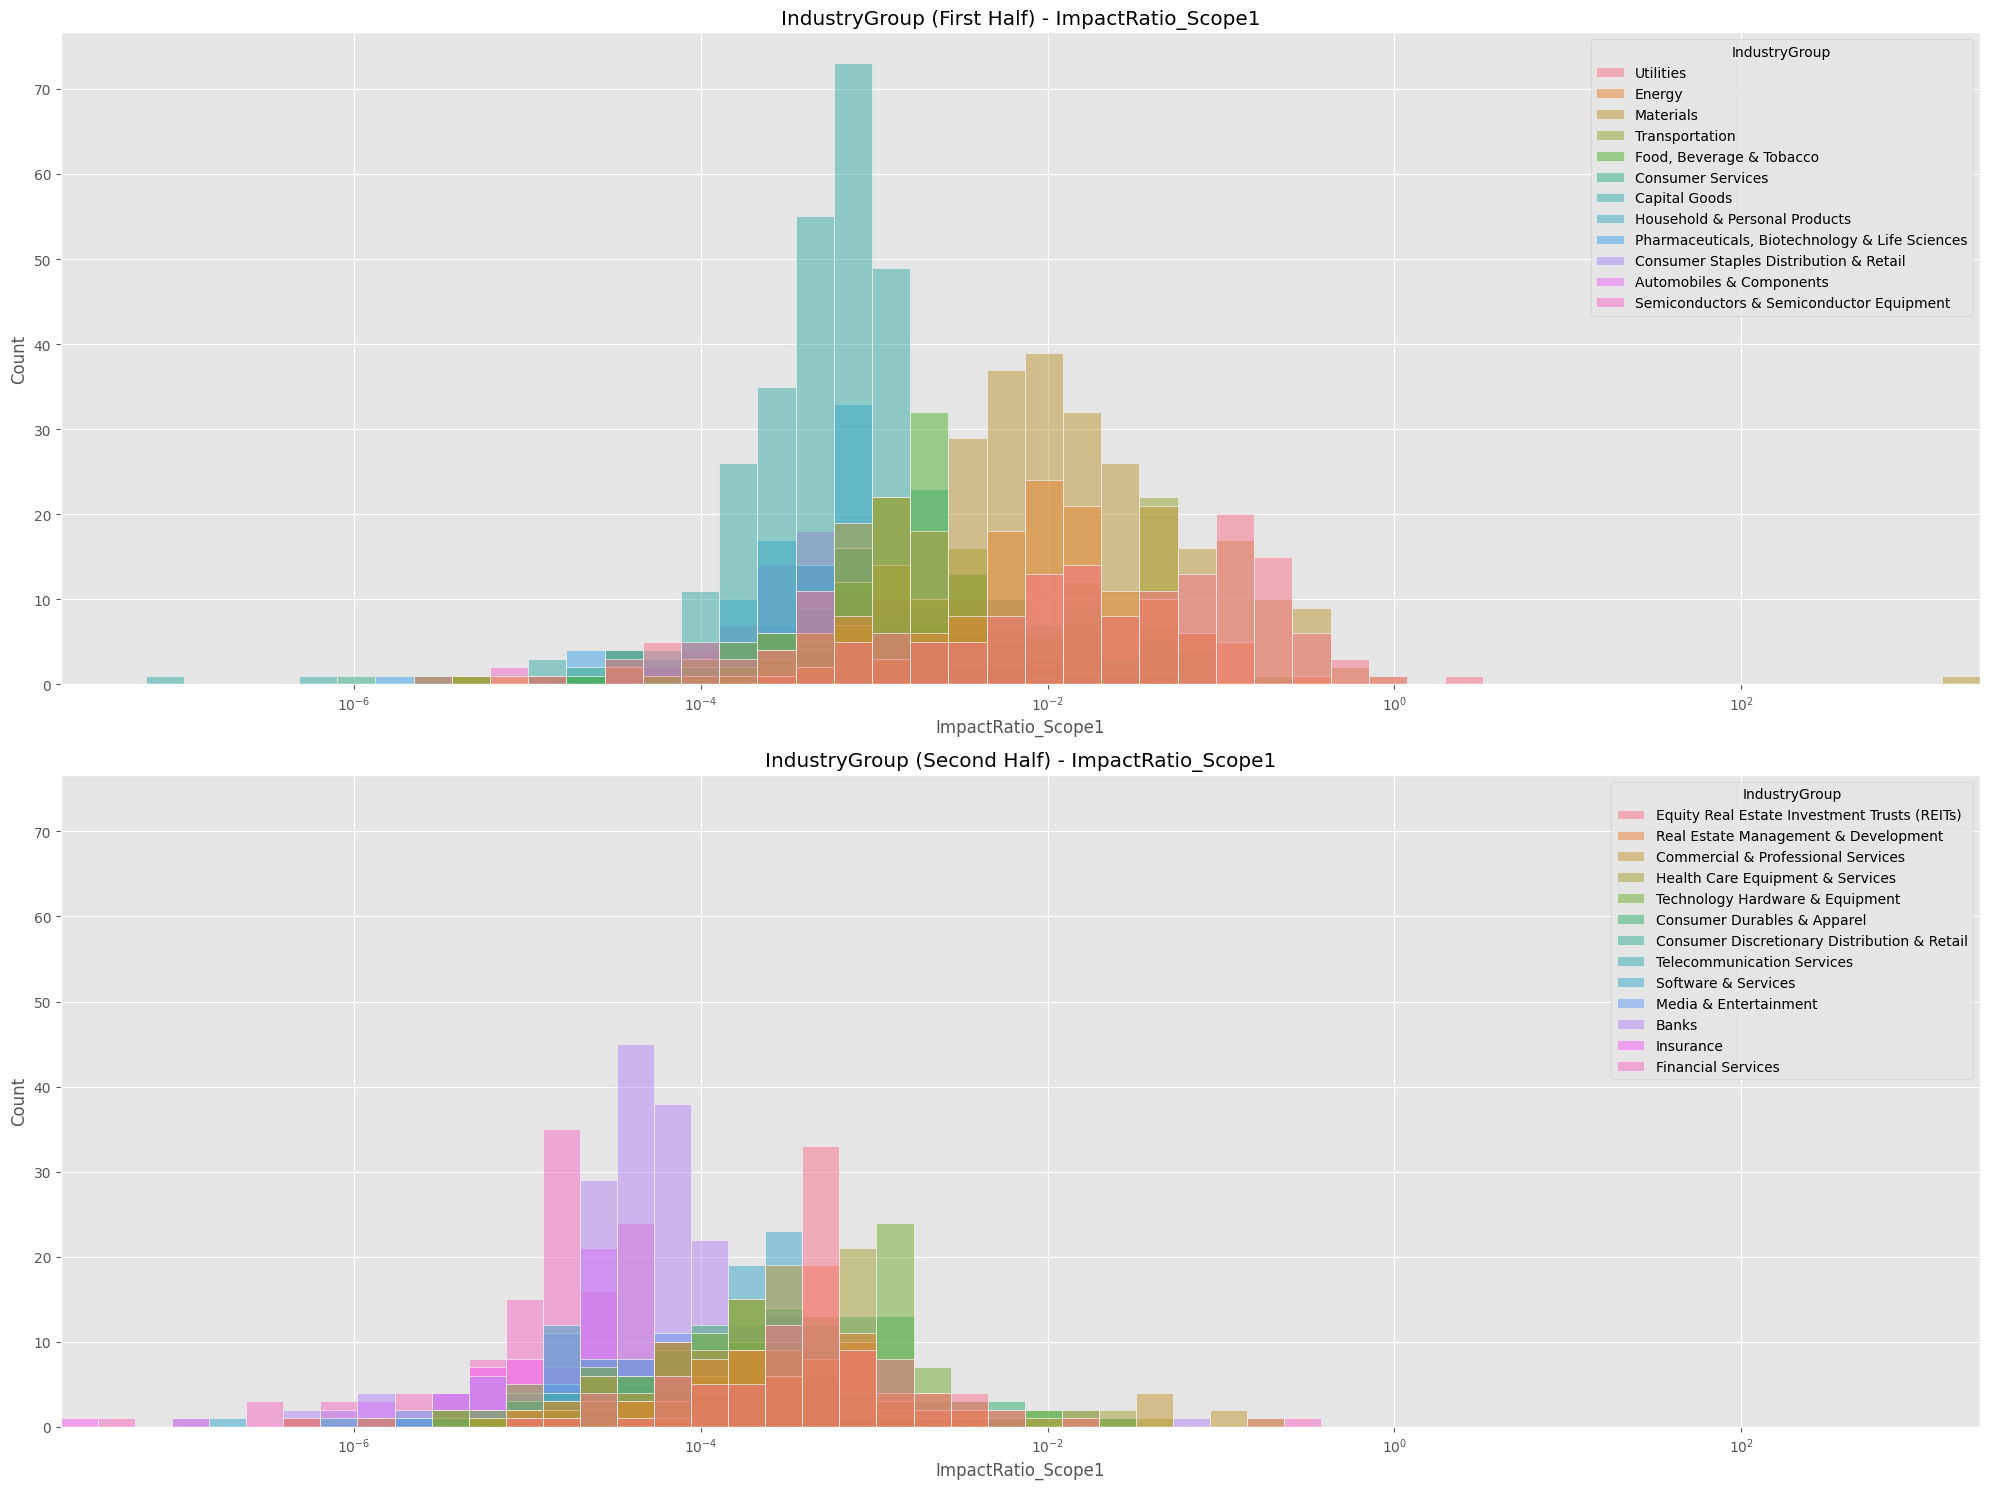

In [259]:
# Careful: In log scale
plot_industrygroup_hist_split(df, order_scope1, "ImpactRatio_Scope1")

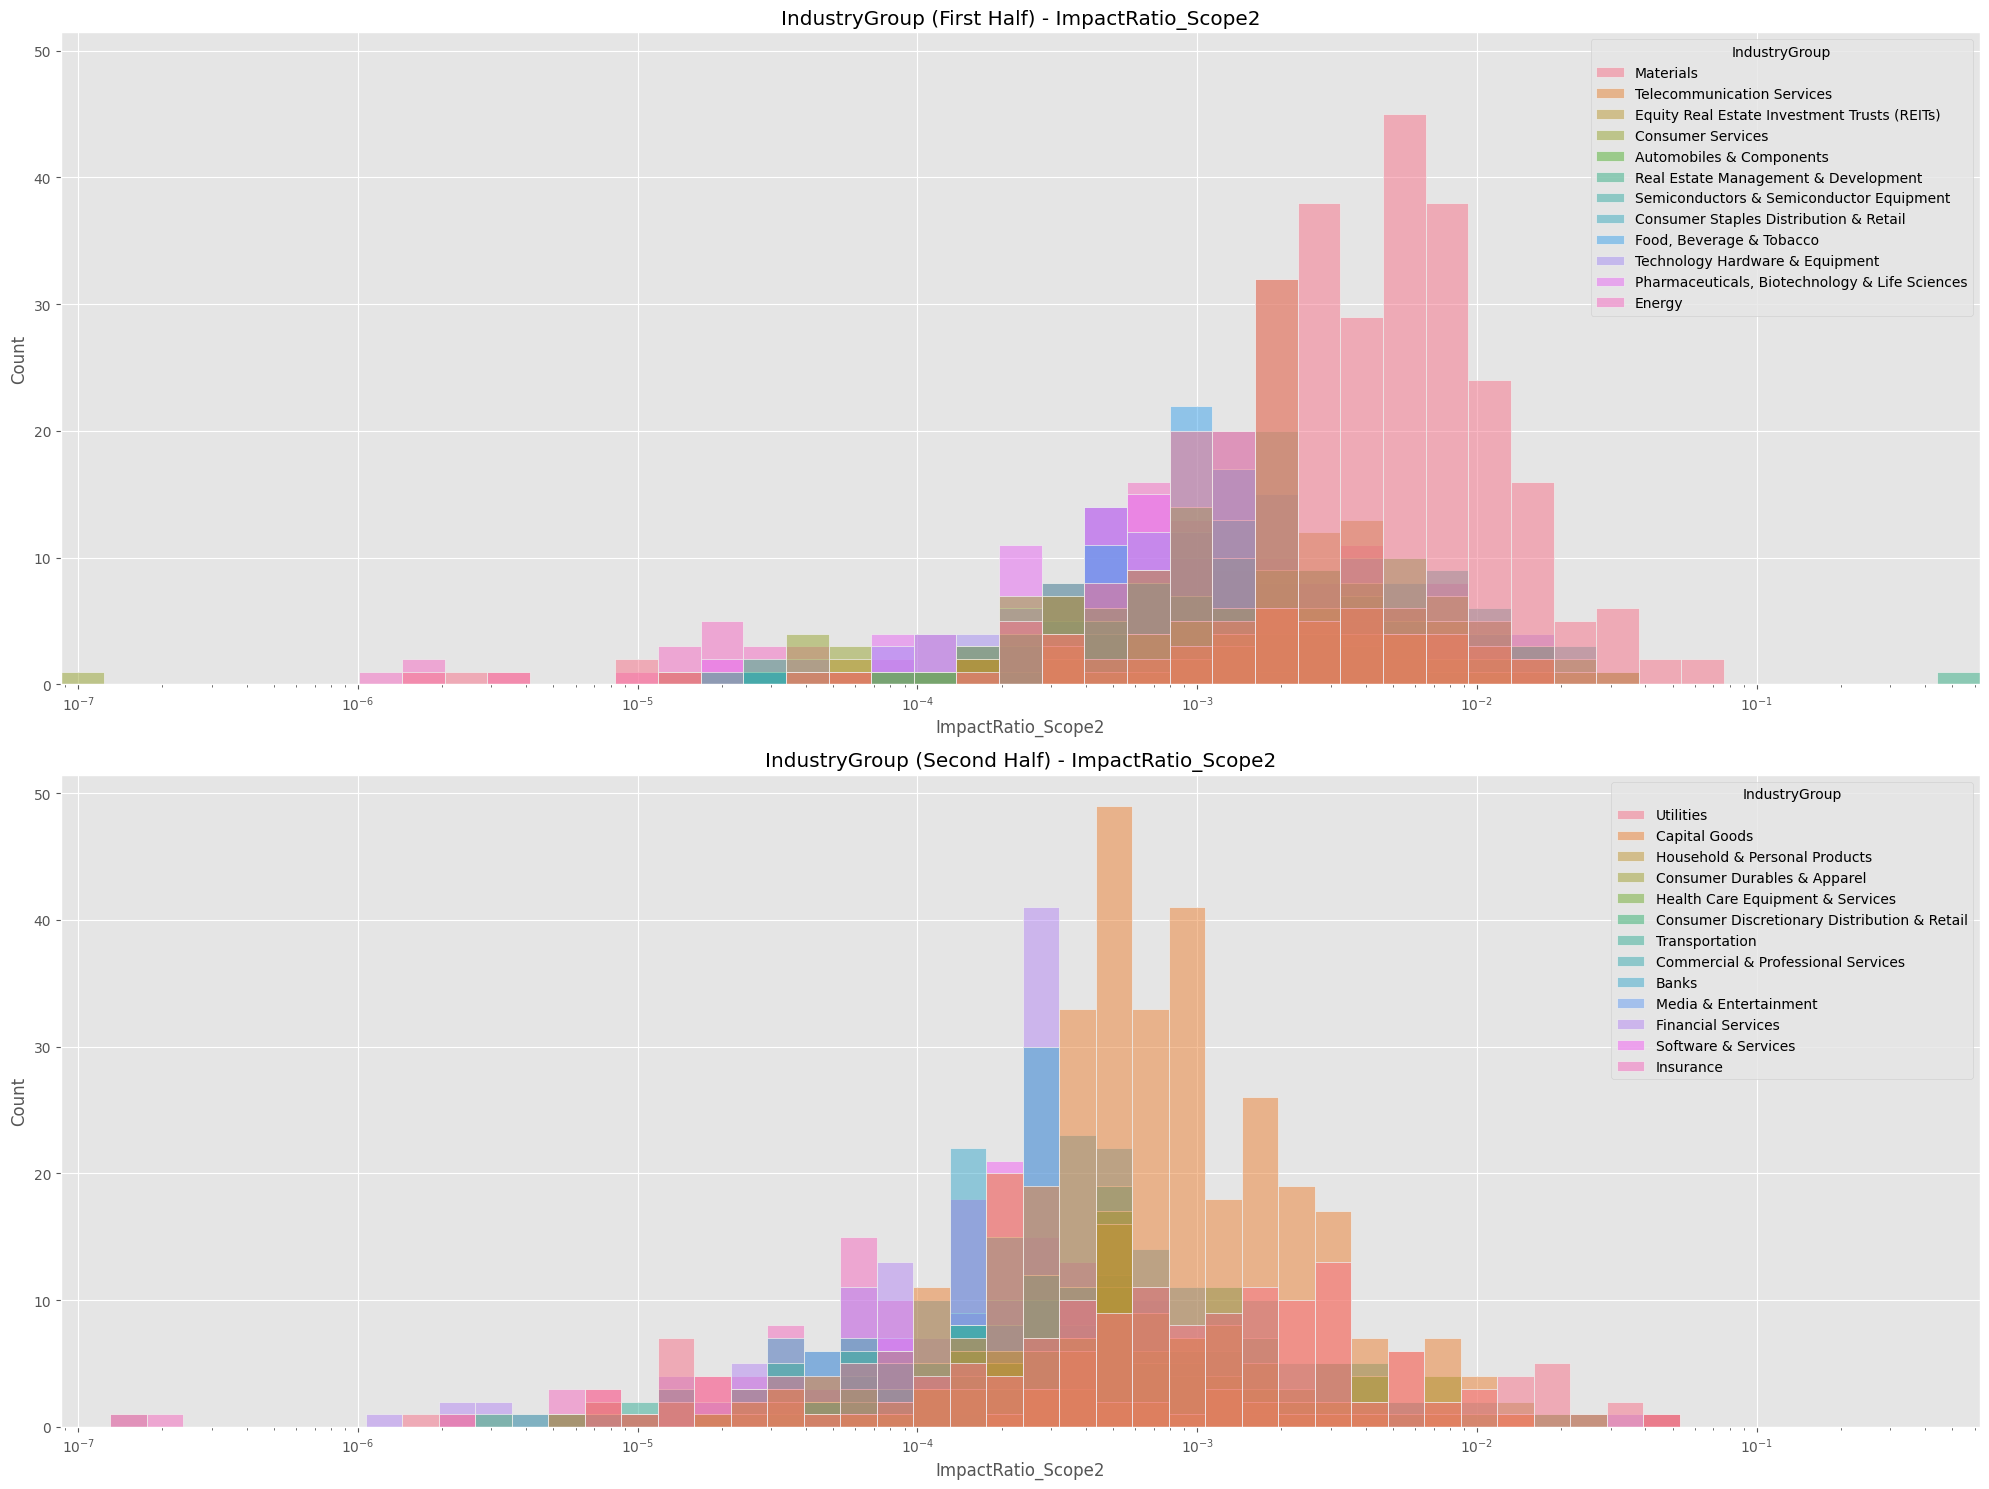

In [260]:
plot_industrygroup_hist_split(df, order_scope2, "ImpactRatio_Scope2")

There are in log-scale, so they are clearly not normally distributed

<Axes: xlabel='Log_ImpactRatio_Scope1', ylabel='Log_ImpactRatio_Scope2'>

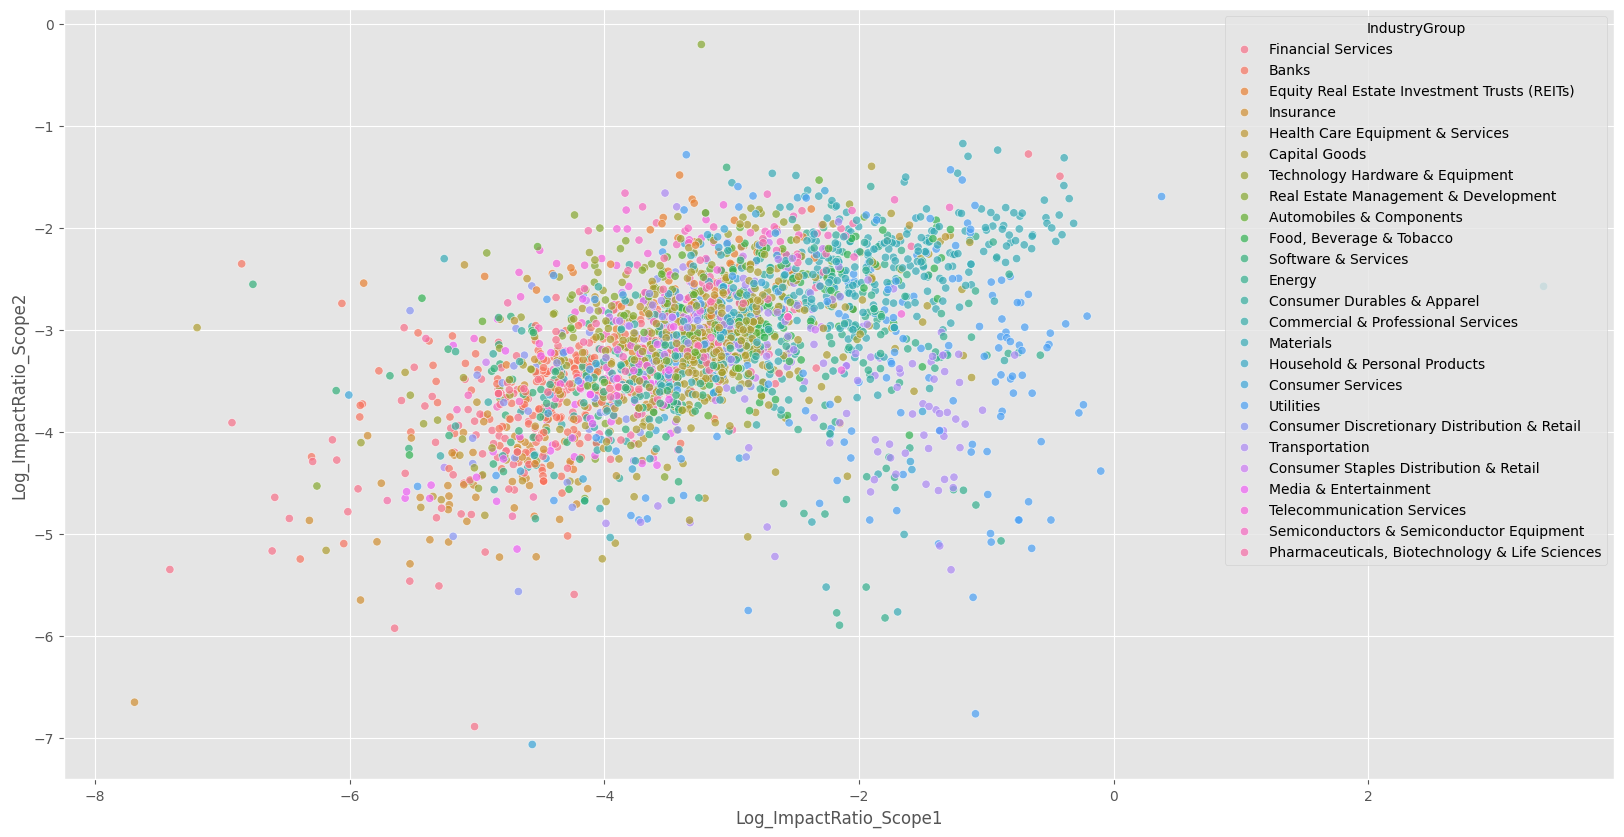

In [261]:
# Plot scatter plot of Impact Ratios
plt.figure(figsize=(20, 10))
sns.scatterplot(
    data=df,
    x="Log_ImpactRatio_Scope1",
    y="Log_ImpactRatio_Scope2",
    hue="IndustryGroup",
    alpha=0.7,
)

**Analyzing Impact Ratios by industry**

In [262]:
# Compare rankings in Scope 1 and Scope 2
df_ranking = pd.DataFrame(
    index=order_scope1, columns=["Scope1_Rank", "Scope2_Rank"], data=np.nan
)

df_ranking["Scope1_Rank"] = df_industry["ImpactRatio_Scope1"].rank(ascending=True)
df_ranking["Scope2_Rank"] = df_industry["ImpactRatio_Scope2"].rank(ascending=True)

df_ranking

Scope1_Rank  Scope2_Rank
IndustryGroup                                                           
Utilities                                              25.0         13.0
Energy                                                 24.0         14.0
Materials                                              23.0         25.0
Transportation                                         22.0          7.0
Food, Beverage & Tobacco                               21.0         17.0
Consumer Services                                      20.0         22.0
Capital Goods                                          19.0         12.0
Household & Personal Products                          18.0         11.0
Pharmaceuticals, Biotechnology & Life Sciences         17.0         15.0
Consumer Staples Distribution & Retail                 16.0         18.0
Automobiles & Components                               15.0         21.0
Semiconductors & Semiconductor Equipment               14.0         19.0
Equity Real Estate Investment Trusts (REITs)           13.0         23.0
Real Estate Management & Development                   12.0         20.0
Commercial & Professional Services                     11.0          6.0
Health Care Equipment & Services                       10.0          9.0
Technology Hardware & Equipment                         9.0         16.0
Consumer Durables & Apparel                             8.0         10.0
Consumer Discretionary Distribution & Retail            7.0          8.0
Telecommunication Services                              6.0         24.0
Software & Services                                     5.0          2.0
Media & Entertainment                                   4.0          4.0
Banks                                                   3.0          5.0
Insurance                                               2.0          1.0
Financial Services                                      1.0          3.0

In [263]:
# Reversing the orders because we move past ratios
order_colors_scope1 = order_colors_scope1[::-1]
order_colors_scope2 = order_colors_scope2[::-1]

<Axes: ylabel='IndustryGroup'>

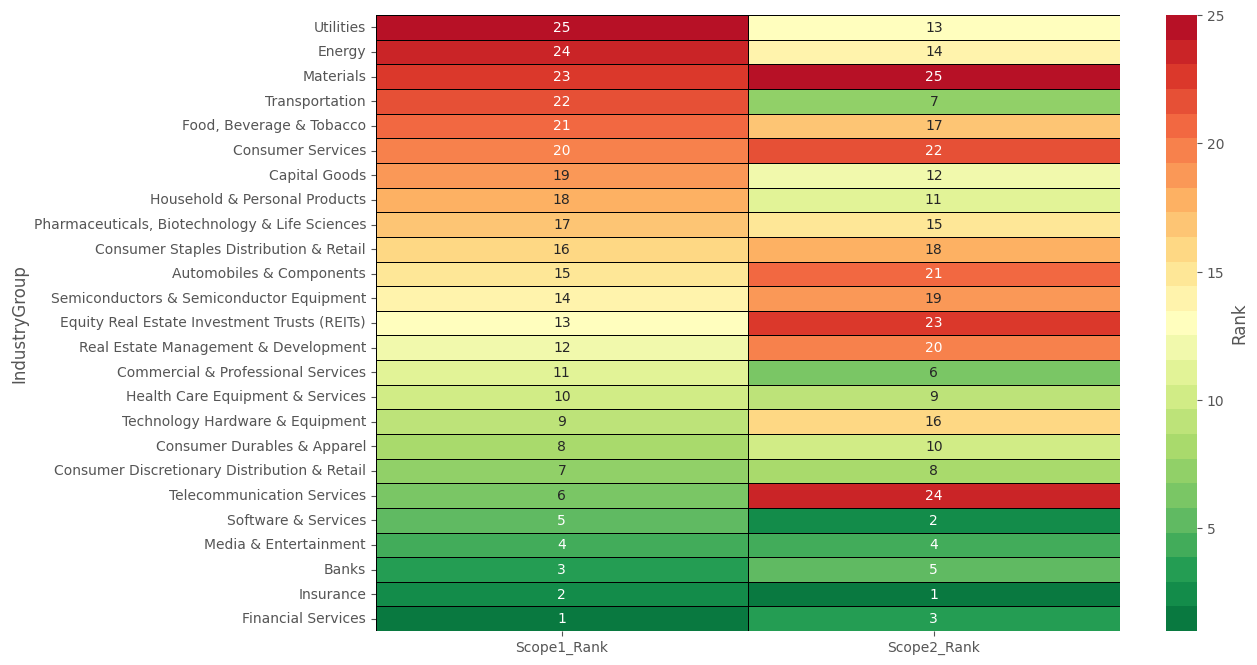

In [264]:
# Plot ranking coloring from green to red each cell
plt.figure(figsize=(12, 8))
sns.heatmap(
    df_ranking[["Scope1_Rank", "Scope2_Rank"]],
    annot=True,
    cmap=order_colors_scope1,
    cbar_kws={"label": "Rank"},
    linewidths=0.5,
    linecolor="black",
    vmin=1,
    vmax=len(order_scope1),
)

To compare them better, I group them in groups of 5

<Axes: ylabel='IndustryGroup'>

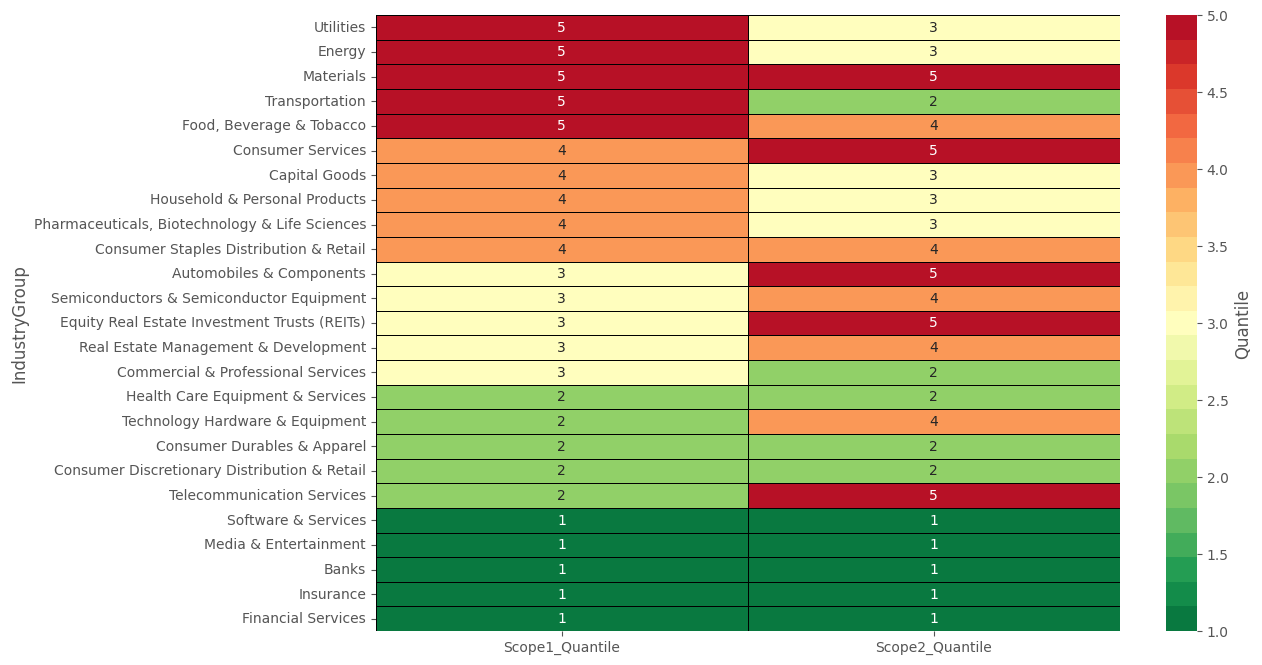

In [265]:
# Group ranking in quantiles and plot them again
df_ranking["Scope1_Quantile"] = (
    pd.qcut(df_ranking["Scope1_Rank"], q=5, labels=False) + 1
)
df_ranking["Scope2_Quantile"] = (
    pd.qcut(df_ranking["Scope2_Rank"], q=5, labels=False) + 1
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    df_ranking[["Scope1_Quantile", "Scope2_Quantile"]],
    annot=True,
    cmap=order_colors_scope1,
    cbar_kws={"label": "Quantile"},
    linewidths=0.5,
    linecolor="black",
    vmin=1,
    vmax=5,
)

# This plot is not fare because it does not take into account outliers

Conclusions:
- Clearly Media&Entertainment, Software&Services, Banks, Insurance and Financial Services have the lowest Impact Ratios
- There are those with high direct emissions and low indirect emissions, such as Transportation, Utilities and Energy
- And those with high indirect emissions and low direct emissions, such as Telecommunication, Technology, REITs

https://finance.yahoo.com/quote/SAN.MC/sustainability/

https://www.santanderassetmanagement.com/content/view/7728/file/SAM_%20SUSTAINABLE%20WEALTH%20ACADEMY_ESG%20RATINGS.pdf

https://www.lseg.com/en/data-analytics/sustainable-finance/esg-scores?esg=Banco+Santander+SA

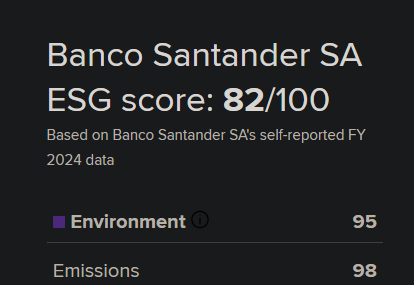
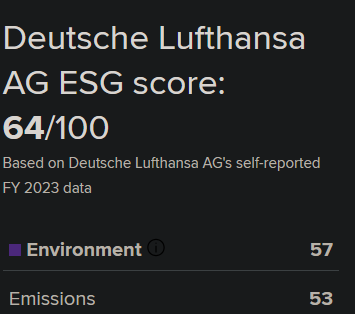
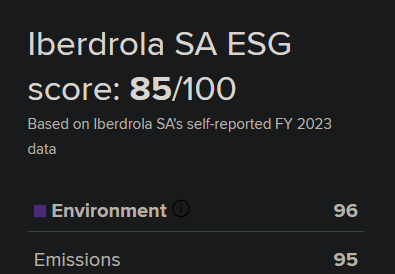

## Exercise 2:
	
> Leveraging the work done in the first exercise, your task now is to deepen the analysis on Impact Ratios, by defining a scoring logic for companies. Each company shall receive a score between 0 and 100 depending on their Scope 1 and Scope 2 Impact Ratios (separately). You’re free to assign the score using the method you consider more relevant, but beware of outliers. 

> Hint: Assign a 0-100 score is easier when the underlying data is normally distributed (or close to normal at least), because in this case simple rank or linear functions can work well. Look at the distribution of Impact Ratios overall, you might want to apply transformations (e.g. natural logarithm) before converting them to scores. 

Seeing that there is a difference in impact ratios between industries, I will assign a score based on the industry.

Although I read that S&P scores cannot be compared across industries, I will also check if I can use the difference across industries in the score. I think it makes sense that a company that has a high impact ratio in an industry with low impact ratios is worse than a company with the same impact ratio in an industry with high impact ratios.

We saw that ratios are not normally distributed, so as hinted I will apply a log transformation.

Regarding the shape of the scores, we should consider what we define as a good or bad.

50 points should be the average? Or maybe we want to penalize more and keep it lower?

In [266]:
# Can be different
df_scores = pd.DataFrame(df["IndustryGroup"], index=df.index)

Approach 1: Percentile in the industry

In [267]:
# TODO: Greater is better
def score_percentile_industry(df, column, industry_column="IndustryGroup"):
    """Score based on percentile in the industry."""
    # TODO: This is just a simple min-max normalization
    df_group = df.groupby(industry_column)[column].transform(
        lambda x: 100 * (1 - (x - x.min()) / (x.max() - x.min()))
    )
    return df_group


# Look min-max of impact ratios per industry
# Unless for certain that the worst is defined, we may want to extrapolate

df_scores["Score1_percentile"] = score_percentile_industry(df, "Log_ImpactRatio_Scope1")
df_scores["Score2_percentile"] = score_percentile_industry(df, "Log_ImpactRatio_Scope2")

df_scores

IndustryGroup  Score1_percentile  Score2_percentile
CompanyID                                                             
COM0001       Financial Services          60.979352          41.156385
COM0002                    Banks          55.904833          45.122981
COM0003                    Banks          57.371634          39.060155
COM0004                    Banks          47.652312          45.756880
COM0005                    Banks          52.251141          39.142359
...                          ...                ...                ...
COM3430    Media & Entertainment          76.581765          71.296366
COM3431                Materials          62.621020          32.553465
COM3432                Materials          62.824331          39.767704
COM3436            Capital Goods          36.651207          48.344480
COM3437           Transportation                NaN          91.536096

[2897 rows x 3 columns]

<Axes: xlabel='Score1_percentile', ylabel='Log_ImpactRatio_Scope1'>

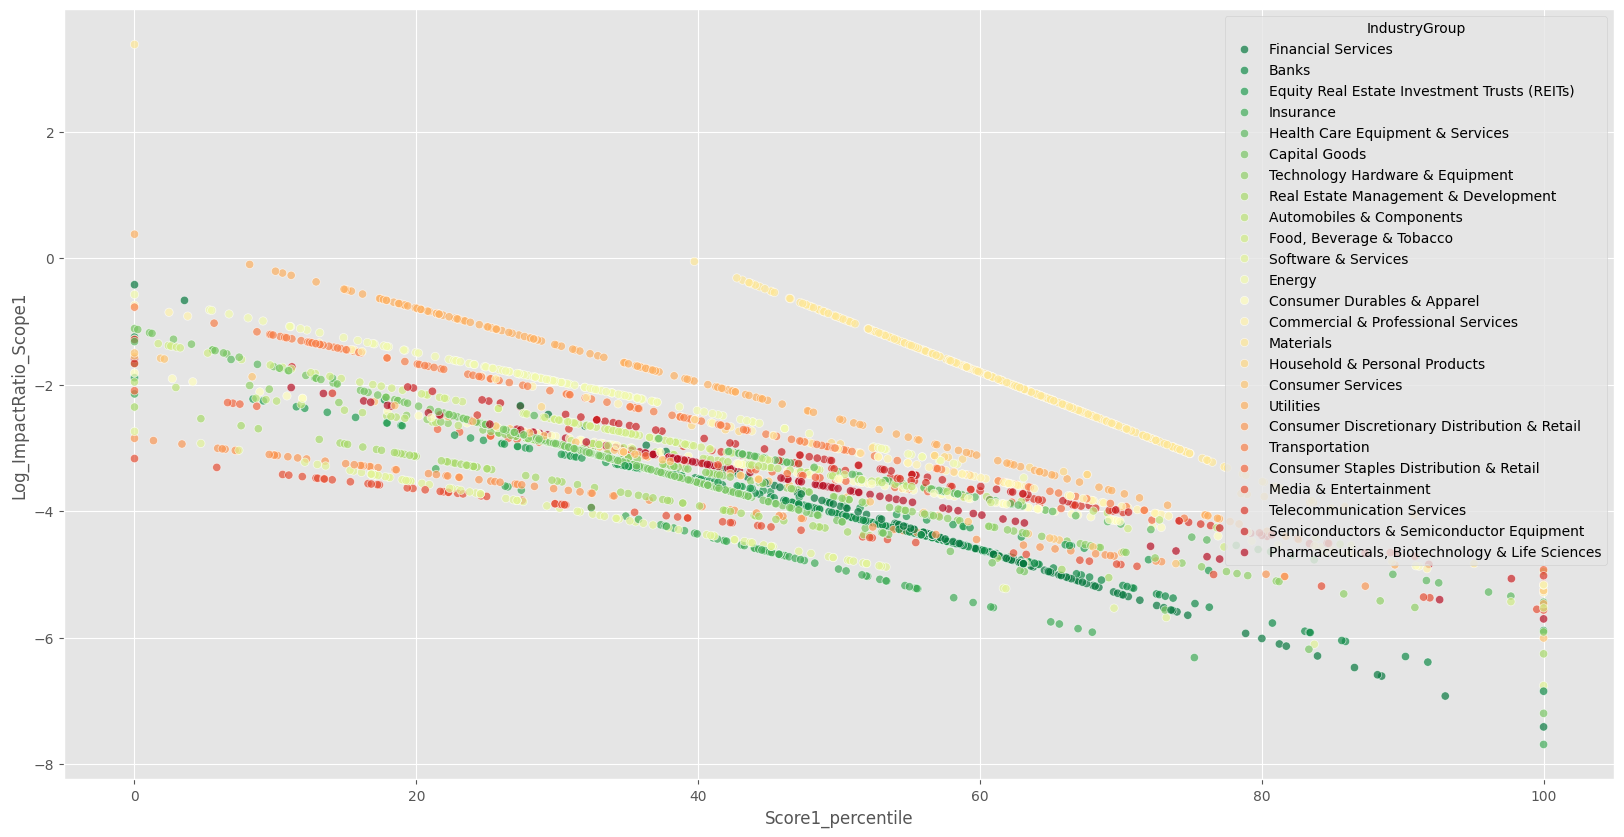

In [268]:
# Plot scatter plot of scores
plt.figure(figsize=(20, 10))
sns.scatterplot(
    x=df_scores["Score1_percentile"],
    y=df["Log_ImpactRatio_Scope1"],
    hue=df["IndustryGroup"],
    alpha=0.7,
    palette=order_colors_scope1,
)

# As expected, a diagonal line

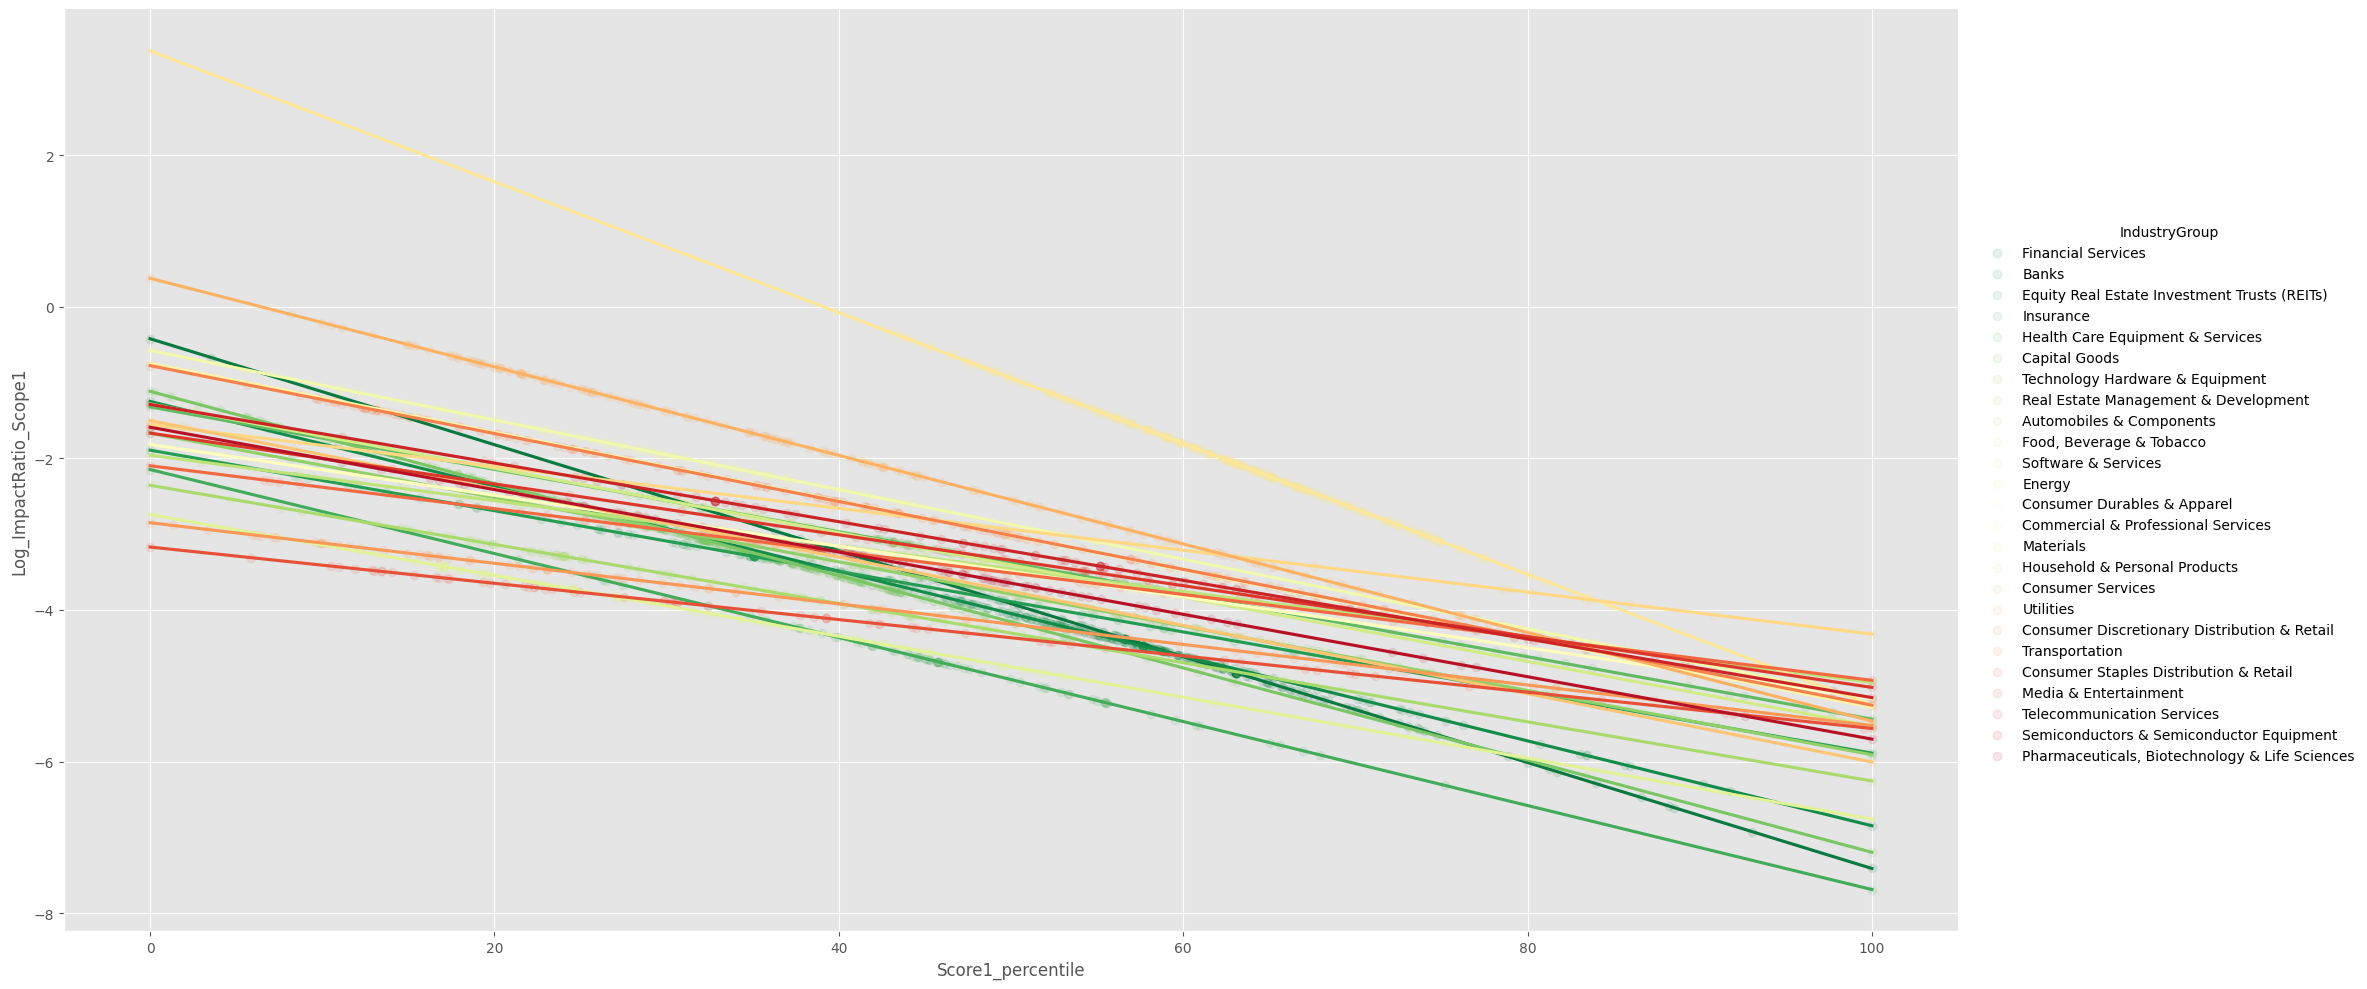

In [269]:
df["Score1_percentile"] = df_scores["Score1_percentile"]

# Plotting lines
sns.lmplot(
    data=df,
    y="Log_ImpactRatio_Scope1",
    x="Score1_percentile",
    hue="IndustryGroup",
    scatter_kws={"alpha": 0.1},
    palette=order_colors_scope1,
    height=10,
    aspect=2,
)
plt.show()

Approach 2: Percentile in the whole dataset

In [270]:
def score_percentile_global(df, column):
    """Score based on percentile in the whole dataset."""
    return 100 * (1 - (df[column] - df[column].min()) / (df[column].max() - df[column].min()))


df_scores["Score1_global"] = score_percentile_global(df, "Log_ImpactRatio_Scope1")
df_scores["Score2_global"] = score_percentile_global(df, "Log_ImpactRatio_Scope2")

df_scores

IndustryGroup  Score1_percentile  Score2_percentile  \
CompanyID                                                                
COM0001       Financial Services          60.979352          41.156385   
COM0002                    Banks          55.904833          45.122981   
COM0003                    Banks          57.371634          39.060155   
COM0004                    Banks          47.652312          45.756880   
COM0005                    Banks          52.251141          39.142359   
...                          ...                ...                ...   
COM3430    Media & Entertainment          76.581765          71.296366   
COM3431                Materials          62.621020          32.553465   
COM3432                Materials          62.824331          39.767704   
COM3436            Capital Goods          36.651207          48.344480   
COM3437           Transportation                NaN          91.536096   

           Score1_global  Score2_global  
CompanyID                                
COM0001        72.841024      49.314805  
COM0002        70.083072      49.613346  
COM0003        70.825240      46.973251  
COM0004        65.907484      49.889381  
COM0005        68.234387      47.009047  
...                  ...            ...  
COM3430        75.726059      61.830168  
COM3431        48.857028      35.937720  
COM3432        49.015652      40.764247  
COM3436        60.739427      44.516408  
COM3437              NaN      70.484580  

[2897 rows x 5 columns]

<Axes: xlabel='Score1_global', ylabel='Log_ImpactRatio_Scope1'>

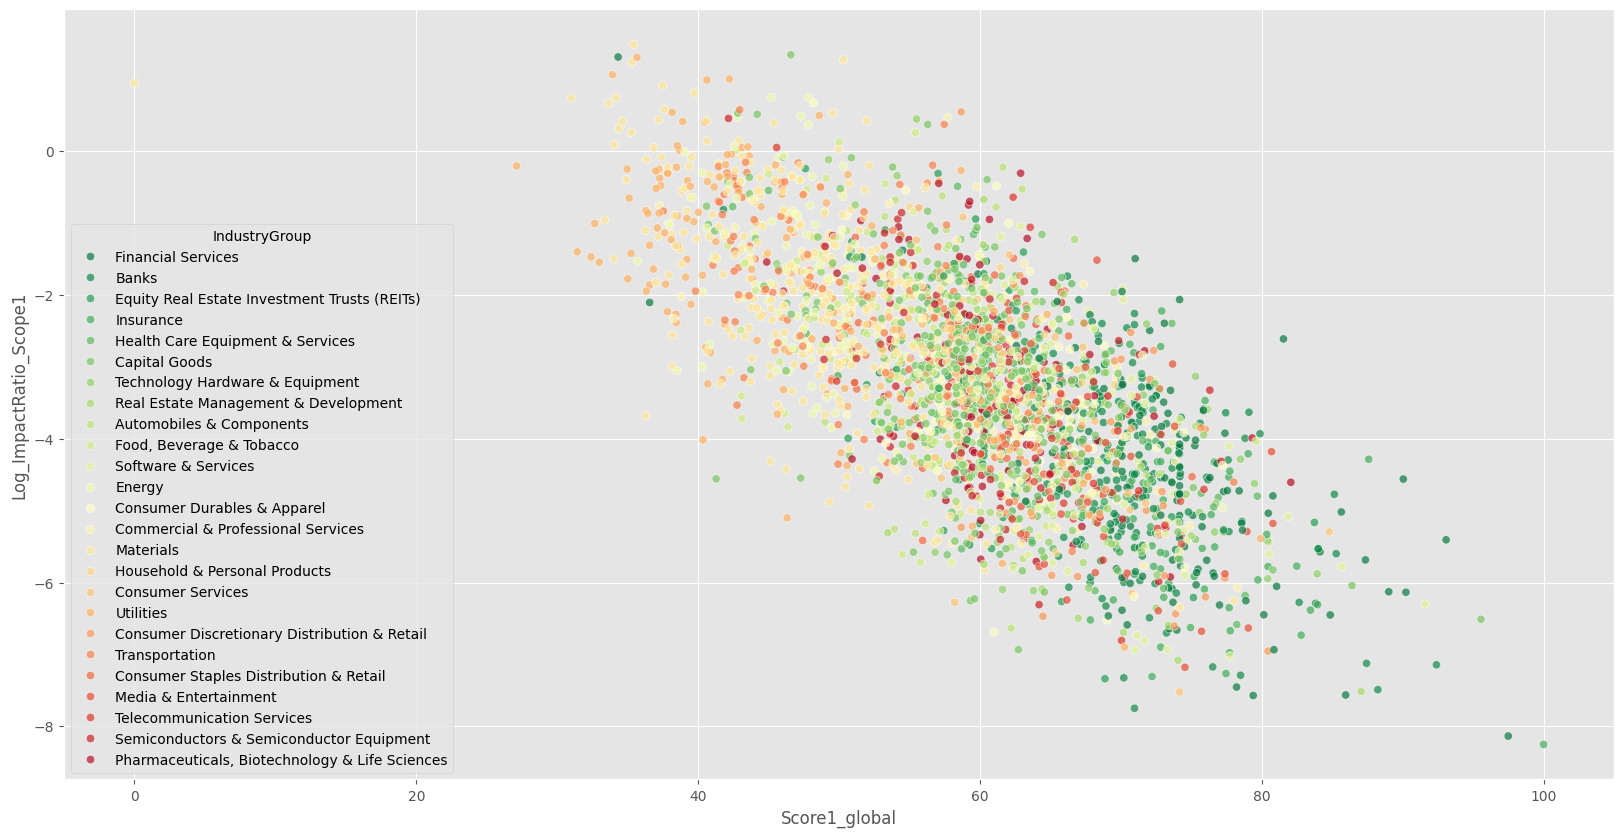

In [271]:
# Plot scatter plot of scores with jitter to avoid point collapse
plt.figure(figsize=(20, 10))
jitter_strength_y = 0.1 * (
    df["Log_ImpactRatio_Scope1"].max() - df["Log_ImpactRatio_Scope1"].min()
)
y_jitter = df["Log_ImpactRatio_Scope1"] + np.random.normal(
    0, jitter_strength_y, size=len(df)
)
sns.scatterplot(
    y=y_jitter,
    x=df_scores["Score1_global"],
    hue=df["IndustryGroup"],
    alpha=0.7,
    palette=order_colors_scope1,
)

Approach 3: Combination of both

In [272]:
combination_weight = 0.7
df_scores["Score1_combined"] = df_scores[
    "Score1_percentile"
] * combination_weight + df_scores["Score1_global"] * (1 - combination_weight)
df_scores["Score2_combined"] = df_scores[
    "Score2_percentile"
] * combination_weight + df_scores["Score2_global"] * (1 - combination_weight)

df_scores

IndustryGroup  Score1_percentile  Score2_percentile  \
CompanyID                                                                
COM0001       Financial Services          60.979352          41.156385   
COM0002                    Banks          55.904833          45.122981   
COM0003                    Banks          57.371634          39.060155   
COM0004                    Banks          47.652312          45.756880   
COM0005                    Banks          52.251141          39.142359   
...                          ...                ...                ...   
COM3430    Media & Entertainment          76.581765          71.296366   
COM3431                Materials          62.621020          32.553465   
COM3432                Materials          62.824331          39.767704   
COM3436            Capital Goods          36.651207          48.344480   
COM3437           Transportation                NaN          91.536096   

           Score1_global  Score2_global  Score1_combined  Score2_combined  
CompanyID                                                                  
COM0001        72.841024      49.314805        64.537854        43.603911  
COM0002        70.083072      49.613346        60.158304        46.470091  
COM0003        70.825240      46.973251        61.407716        41.434084  
COM0004        65.907484      49.889381        53.128864        46.996630  
COM0005        68.234387      47.009047        57.046115        41.502365  
...                  ...            ...              ...              ...  
COM3430        75.726059      61.830168        76.325054        68.456506  
COM3431        48.857028      35.937720        58.491822        33.568742  
COM3432        49.015652      40.764247        58.681727        40.066667  
COM3436        60.739427      44.516408        43.877673        47.196059  
COM3437              NaN      70.484580              NaN        85.220641  

[2897 rows x 7 columns]

<Axes: xlabel='Score1_combined', ylabel='Log_ImpactRatio_Scope1'>

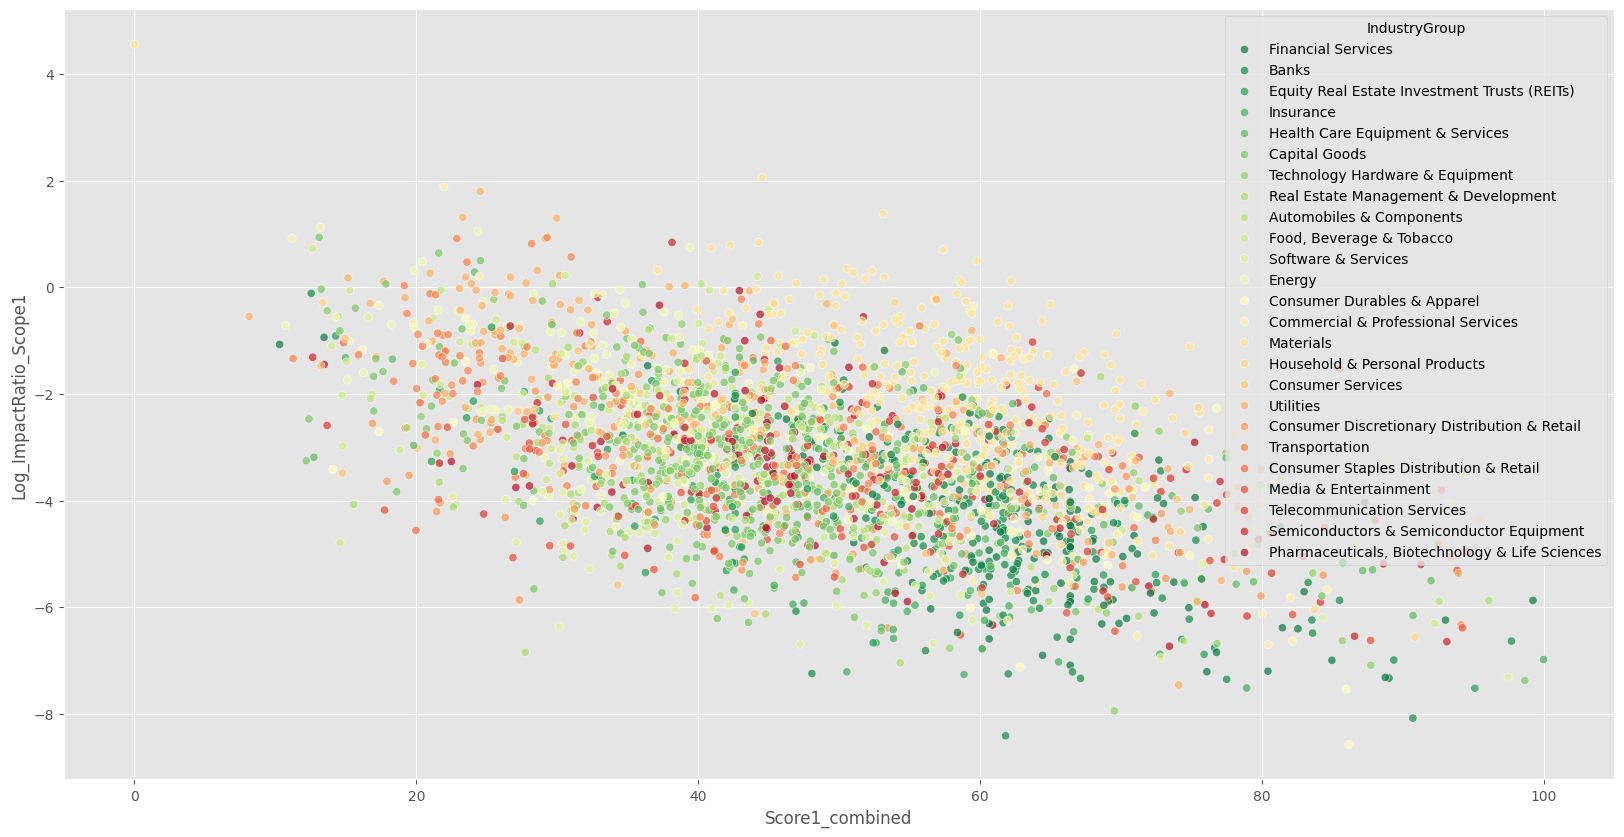

In [273]:
# Plot scatter plot of scores with jitter to avoid point collapse
plt.figure(figsize=(20, 10))

jitter_strength_y = 0.1 * (
    df["Log_ImpactRatio_Scope1"].max() - df["Log_ImpactRatio_Scope1"].min()
)
y_jitter = df["Log_ImpactRatio_Scope1"] + np.random.normal(
    0, jitter_strength_y, size=len(df)
)

sns.scatterplot(
    y=y_jitter,
    x=df_scores["Score1_combined"],
    hue=df["IndustryGroup"],
    alpha=0.7,
    palette=order_colors_scope1,
)

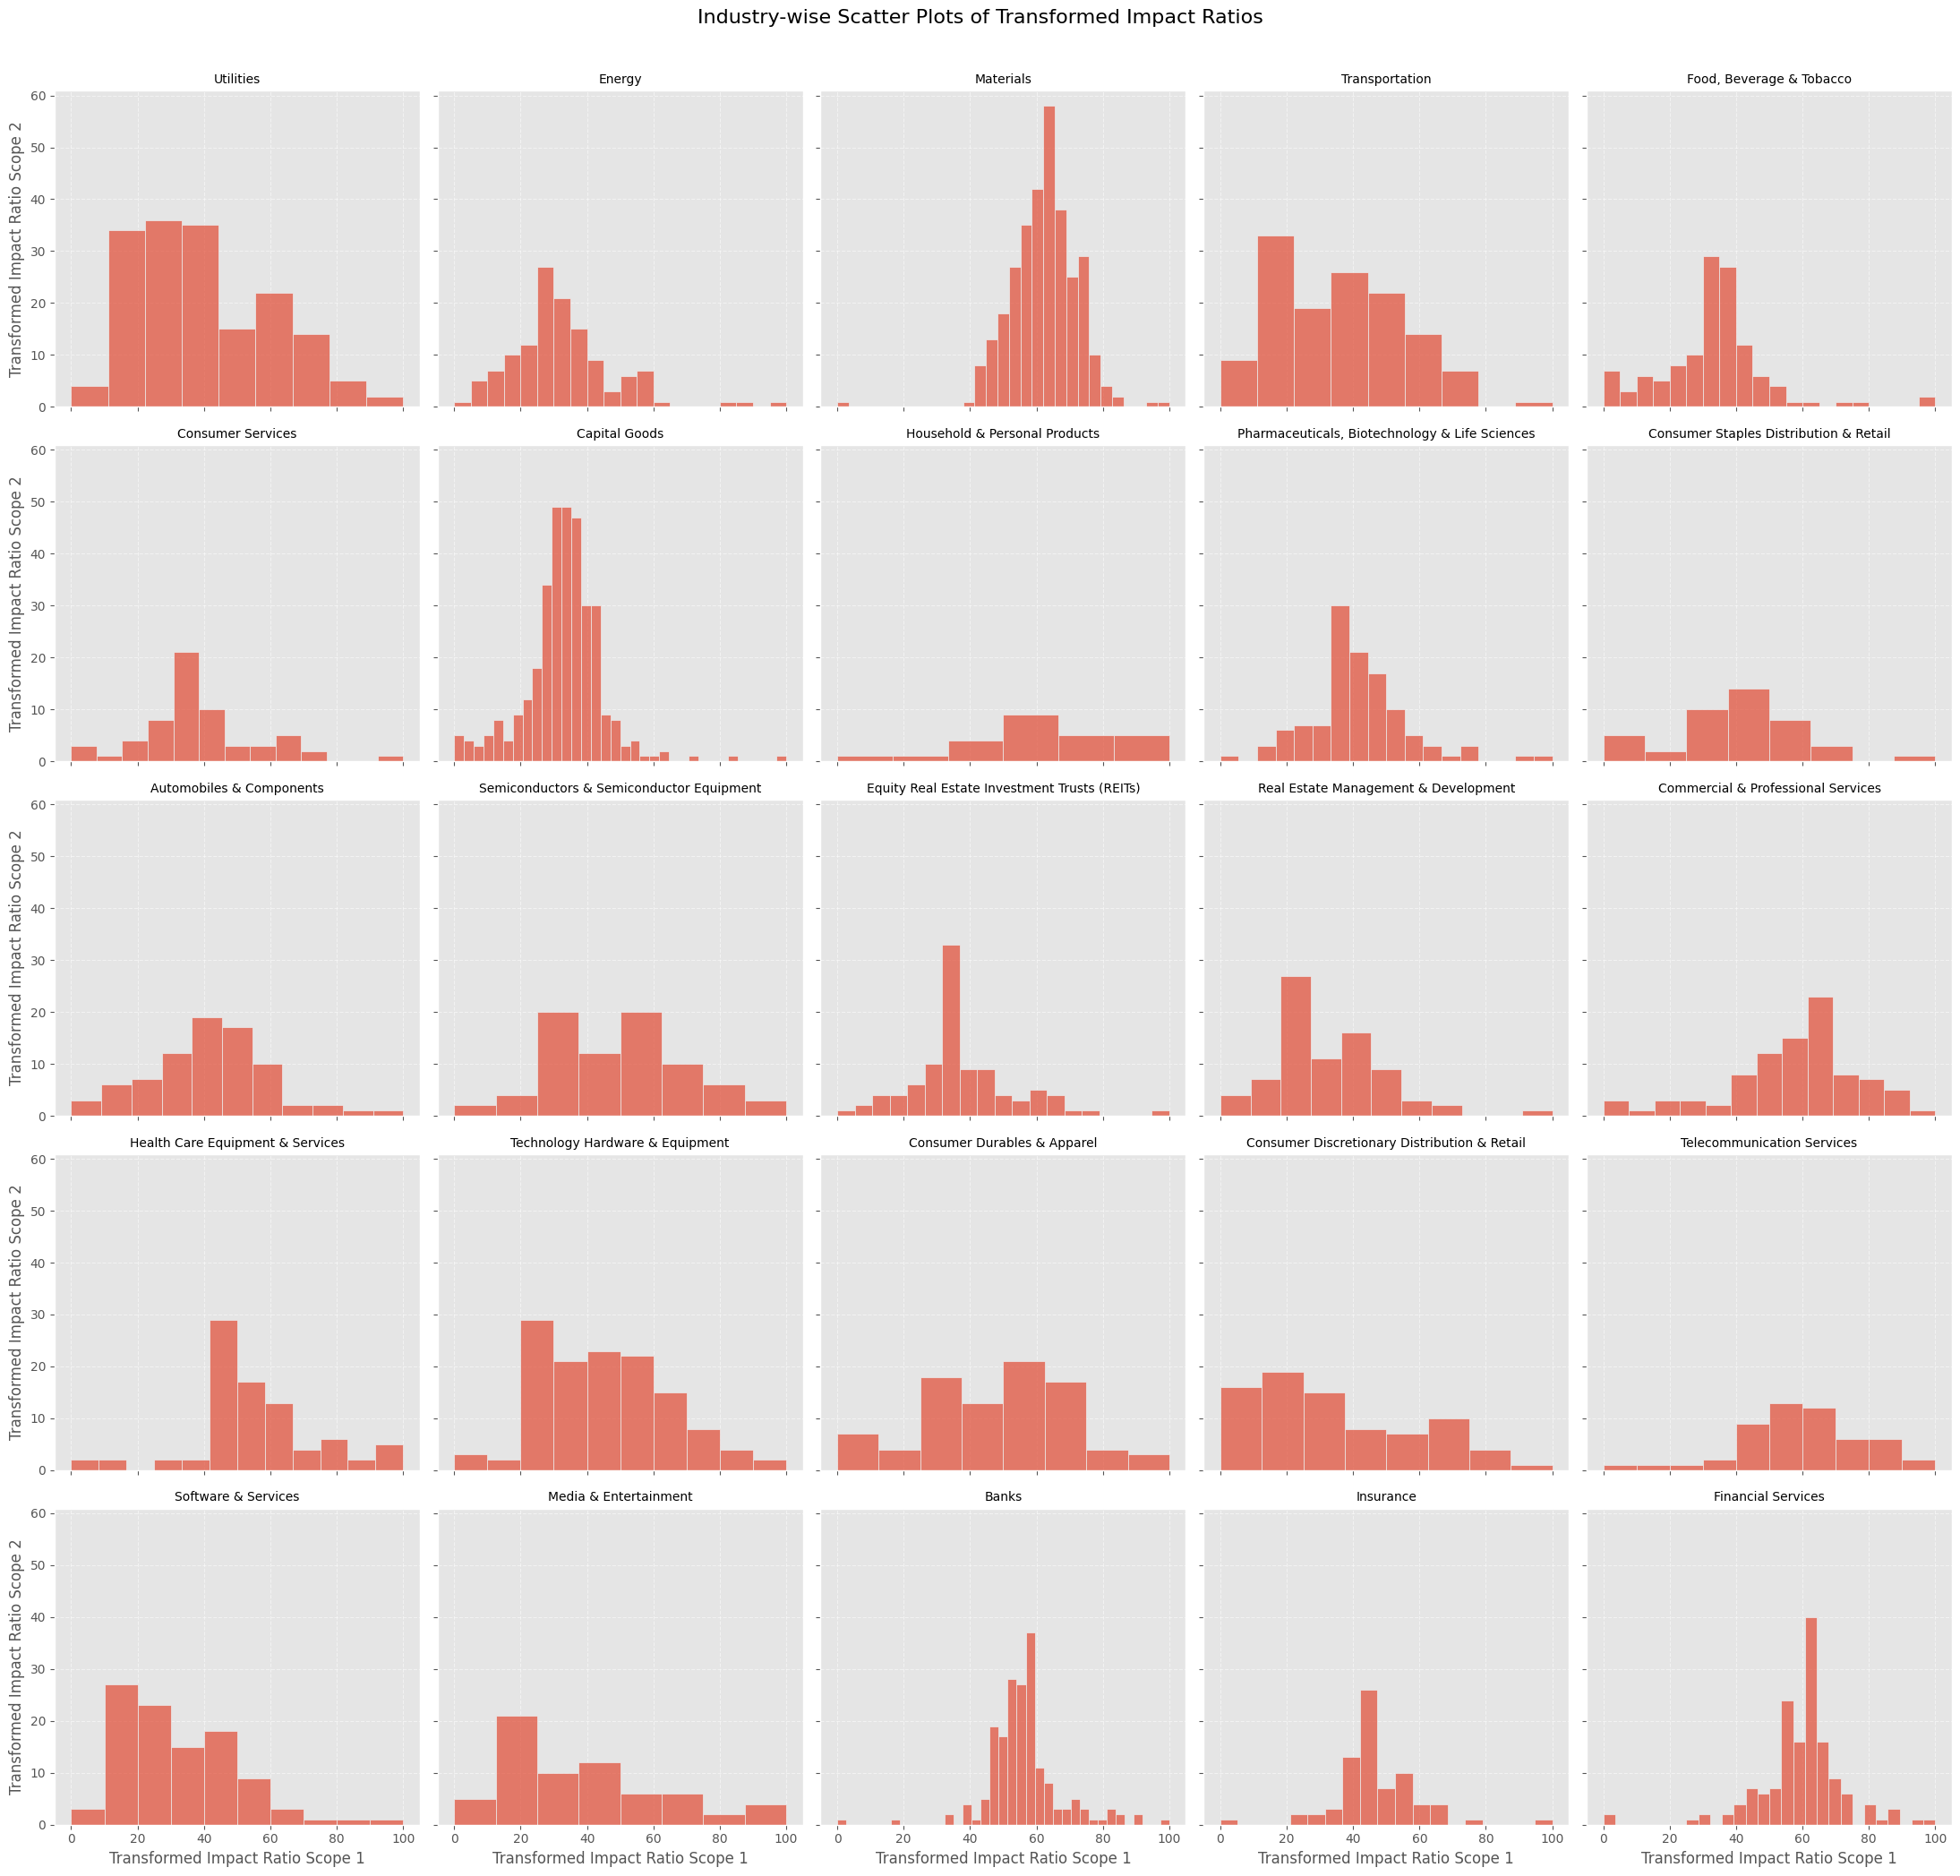

In [274]:
# Improved 5x5 grid of scatter plots for each industry
n_rows = 5
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 22), sharex=True, sharey=True)
for i, industry in enumerate(order_scope1):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    sns.histplot(
        # data=df[df["IndustryGroup"] == industry],
        # x="Log_ImpactRatio_Scope1",
        data=df_scores[df["IndustryGroup"] == industry],
        x="Score1_percentile",
        ax=ax,
        # hue="IndustryGroup",
        # palette=[order_colors[-i]],
        alpha=0.7,
        legend=False,
    )
    # sns.scatterplot(
    #     data=df[df["IndustryGroup"] == industry],
    #     x="Log_ImpactRatio_Scope1",
    #     y="Log_ImpactRatio_Scope2",
    #     ax=ax,
    #     hue="IndustryGroup",
    #     palette=[order_colors[-i]],
    #     alpha=0.7,
    #     s=40,  # marker size
    #     legend=False,
    # )
    ax.set_title(industry, fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.5)
    if row == n_rows - 1:
        ax.set_xlabel("Transformed Impact Ratio Scope 1")
    else:
        ax.set_xlabel("")
    if col == 0:
        ax.set_ylabel("Transformed Impact Ratio Scope 2")
    else:
        ax.set_ylabel("")

plt.suptitle("Industry-wise Scatter Plots of Transformed Impact Ratios", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

**Scoring the missing values**

For the missing values, I will assign a score based on the average of the industry.

In [290]:
avg_scores = df_scores.groupby("IndustryGroup").mean()
avg_scores

Score1_percentile  \
IndustryGroup                                                       
Automobiles & Components                                41.700015   
Banks                                                   56.237683   
Capital Goods                                           32.994419   
Commercial & Professional Services                      57.059623   
Consumer Discretionary Distribution & Retail            34.823159   
Consumer Durables & Apparel                             48.512855   
Consumer Services                                       38.750728   
Consumer Staples Distribution & Retail                  40.835880   
Energy                                                  32.543720   
Equity Real Estate Investment Trusts (REITs)            37.875115   
Financial Services                                      59.605216   
Food, Beverage & Tobacco                                33.230060   
Health Care Equipment & Services                        54.561624   
Household & Personal Products                           61.558442   
Insurance                                               46.962115   
Materials                                               62.227460   
Media & Entertainment                                   38.218154   
Pharmaceuticals, Biotechnology & Life Sciences          41.662612   
Real Estate Management & Development                    32.545696   
Semiconductors & Semiconductor Equipment                50.233879   
Software & Services                                     32.482791   
Technology Hardware & Equipment                         45.625932   
Telecommunication Services                              60.031478   
Transportation                                          35.497987   
Utilities                                               40.163895   

                                                Score2_percentile  \
IndustryGroup                                                       
Automobiles & Components                                53.826503   
Banks                                                   44.447369   
Capital Goods                                           46.516593   
Commercial & Professional Services                      48.298465   
Consumer Discretionary Distribution & Retail            28.718498   
Consumer Durables & Apparel                             52.205270   
Consumer Services                                       26.124737   
Consumer Staples Distribution & Retail                  36.770624   
Energy                                                  34.855706   
Equity Real Estate Investment Trusts (REITs)            35.351112   
Financial Services                                      45.878054   
Food, Beverage & Tobacco                                36.135524   
Health Care Equipment & Services                        48.280335   
Household & Personal Products                           66.058833   
Insurance                                               30.235493   
Materials                                               29.227273   
Media & Entertainment                                   40.549855   
Pharmaceuticals, Biotechnology & Life Sciences          41.051233   
Real Estate Management & Development                    61.593391   
Semiconductors & Semiconductor Equipment                42.999915   
Software & Services                                     67.962666   
Technology Hardware & Equipment                         44.147554   
Telecommunication Services                              39.190934   
Transportation                                          47.939341   
Utilities                                               36.415804   

                                                Score1_global  Score2_global  \
IndustryGroup                                                                  
Automobiles & Components                            59.509482      37.491570   
Banks                                               70.251487      49.319146   


In [ ]:
def fillna_with_industry_mean(df, value_column, industry_column="IndustryGroup"):
    """
    Fill NA values in `value_column` with the mean of the corresponding industry.
    """
    return df.groupby(industry_column)[value_column].transform(
        lambda x: x.fillna(x.mean())
    )

CompanyID
COM0001    64.537854
COM0002    60.158304
COM0003    61.407716
COM0004    53.128864
COM0005    57.046115
             ...    
COM3465    58.124214
COM3466    42.862061
COM3467    63.315550
COM3468    47.273837
COM3469    58.142543
Name: Score1_combined, Length: 6329, dtype: float64

In [300]:
# Adding missing values
df_scores = pd.concat([df_scores, df_nan], axis=0)

# Add mean of industry for missing values
df_scores["Score1_combined"] = fillna_with_industry_mean(df_scores, "Score1_combined")
df_scores["Score2_combined"] = fillna_with_industry_mean(df_scores, "Score2_combined")


df_scores

IndustryGroup  Score1_percentile  \
CompanyID                                                                      
COM0001                                Financial Services          60.979352   
COM0002                                             Banks          55.904833   
COM0003                                             Banks          57.371634   
COM0004                                             Banks          47.652312   
COM0005                                             Banks          52.251141   
...                                                   ...                ...   
COM3465                                         Materials                NaN   
COM3466                               Software & Services                NaN   
COM3467                                Financial Services                NaN   
COM3468    Pharmaceuticals, Biotechnology & Life Sciences                NaN   
COM3469                Commercial & Professional Services                NaN   

           Score2_percentile  Score1_global  Score2_global  Score1_combined  \
CompanyID                                                                     
COM0001            41.156385      72.841024      49.314805        64.537854   
COM0002            45.122981      70.083072      49.613346        60.158304   
COM0003            39.060155      70.825240      46.973251        61.407716   
COM0004            45.756880      65.907484      49.889381        53.128864   
COM0005            39.142359      68.234387      47.009047        57.046115   
...                      ...            ...            ...              ...   
COM3465                  NaN            NaN            NaN        58.124214   
COM3466                  NaN            NaN            NaN        42.862061   
COM3467                  NaN            NaN            NaN        63.315550   
COM3468                  NaN            NaN            NaN        47.273837   
COM3469                  NaN            NaN            NaN        58.142543   

           Score2_combined  Score1_combined_avg  TotalRevenue  \
CompanyID                                                       
COM0001          43.603911            63.315550           NaN   
COM0002          46.470091            60.441824           NaN   
COM0003          41.434084            60.441824           NaN   
COM0004          46.996630            60.441824           NaN   
COM0005          41.502365            60.441824           NaN   
...                    ...                  ...           ...   
COM3465          30.572813                  NaN           NaN   
COM3466          62.552099                  NaN           NaN   
COM3467          48.067602                  NaN           NaN   
COM3468          41.237979                  NaN           NaN   
COM3469          48.006565                  NaN           NaN   

           DamageCost_Scope1  DamageCost_Scope2  
CompanyID                                        
COM0001                  NaN                NaN  
COM0002                  NaN                NaN  
COM0003                  NaN                NaN  
COM0004                  NaN                NaN  
COM0005                  NaN                NaN  
...                      ...                ...  
COM3465                  NaN                NaN  
COM3466                  NaN                NaN  
COM3467                  NaN                NaN  
COM3468                  NaN                NaN  
COM3469                  NaN                NaN  

[7473 rows x 11 columns]

## References

ESG Scores and Raw Data
https://www.spglobal.com/sustainable1/en/solutions/esg-scores-data

S&P Global ESG Scores Methodology
https://portal.s1.spglobal.com/survey/documents/spglobal_esg_scores_methodology.pdf

CSA Methodology
https://www.spglobal.com/sustainable1/en/csa/methodology

The S&P Global ESG Score cannot be compared across industries

The S&P Global ESG Score uses a double materiality approach whereby a sustainability issue is considered to be material if it presents a significant impact on society or the environment and a significant impact on a company's value drivers, competitive position, and long-term shareholder value creation.